In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #買入手續費 = (今天收盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #賣出手續費 = (明天開盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 明天開盤 * 稅率

                    Buy = current_price + Buy_trade_fee #買入成本 = 今天收盤 + 買入手續費
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax #賣出成本 = 明天開盤 - 賣出手續費 - 證交稅


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）
                
                
                
                
                elif(action == Actions.Sell.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #買入手續費 = (明天開盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #賣出手續費 = (今天收盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 今天收盤 * 稅率

                    Buy = last_trade_price + Buy_trade_fee #買入成本 = 明天開盤 + 買入手續費
                    Sold = current_price - Sold_trade_fee - Transfer_tax #賣出成本 = 今天收盤 - 賣出手續費 - 證交稅    

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0             
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000          

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = current_price + Buy_trade_fee#買入的成本
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax#賣出的成本

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    long_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = last_trade_price + Buy_trade_fee#買入的成本
                    Sold = current_price - Sold_trade_fee - Transfer_tax#賣出的成本


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    short_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('2330.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('2330.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,2000-01-31,77.474,79.823,77.083,79.431,40.364,168059342623.000,2330.TW,70.823,82.561,...,77.777,80.228,79.952,2.537,1.571,81.099,73.014,64.929,0,1
1,2000-02-01,80.214,80.214,78.648,79.040,40.166,153081850577.000,2330.TW,70.823,82.561,...,73.809,76.819,78.908,2.585,1.773,81.819,73.484,65.148,0,1
2,2000-02-02,79.040,79.040,79.040,79.040,40.166,0.000,2330.TW,71.214,82.561,...,70.270,74.201,77.339,2.592,1.937,82.478,73.875,65.272,0,1
3,2000-02-03,79.040,79.040,79.040,79.040,40.166,0.000,2330.TW,73.171,82.561,...,76.470,70.301,74.993,2.569,2.064,82.999,74.344,65.690,0,1
4,2000-02-04,79.040,79.040,79.040,79.040,40.166,0.000,2330.TW,74.344,82.561,...,76.470,65.915,71.967,2.521,2.155,83.229,74.912,66.595,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,2023-02-23,512.000,521.000,510.000,518.000,518.000,25376835.000,2330.TW,505.000,546.000,...,47.059,22.510,29.363,6.838,11.746,553.768,528.450,503.132,0,1
5756,2023-02-24,524.000,525.000,511.000,511.000,511.000,41692491.000,2330.TW,505.000,546.000,...,30.667,19.885,26.203,5.500,10.497,552.760,528.850,504.940,1,0
5757,2023-03-01,504.000,522.000,504.000,522.000,522.000,39560848.000,2330.TW,504.000,532.000,...,39.535,34.685,29.031,5.268,9.451,550.965,527.800,504.635,1,0
5758,2023-03-02,519.000,520.000,515.000,519.000,519.000,16558784.000,2330.TW,504.000,531.000,...,34.524,41.642,33.234,4.786,8.518,551.002,527.650,504.298,0,1


# 查找DF的標籤

In [6]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

4992

In [7]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

5725

In [8]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
4992,2020-01-02,332.500,339.000,332.500,339.000,316.967,31754120.000,2330.TW,328.500,339.000,...,52.830,56.781,49.078,6.590,7.294,350.319,330.400,310.481,1,0
4993,2020-01-03,344.000,345.000,335.500,339.500,317.434,41811268.000,2330.TW,329.500,345.000,...,43.820,59.359,52.505,6.601,7.156,350.161,331.775,313.389,1,0
4994,2020-01-06,333.000,334.500,332.000,332.000,310.422,45343057.000,2330.TW,331.000,345.000,...,37.864,41.954,48.988,5.937,6.912,348.971,332.725,316.479,1,0
4995,2020-01-07,332.500,333.000,326.500,329.500,308.084,50879181.000,2330.TW,326.500,345.000,...,43.820,33.375,43.783,5.149,6.559,347.831,333.400,318.969,1,0
4996,2020-01-08,325.000,333.000,325.000,329.500,308.084,37567748.000,2330.TW,325.000,345.000,...,50.649,29.750,39.106,4.473,6.142,345.582,334.200,322.818,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5721,2022-12-26,454.000,457.000,453.500,456.500,456.500,8793306.000,2330.TW,453.500,481.500,...,40.260,15.713,19.788,-0.244,4.264,499.698,475.200,450.702,0,1
5722,2022-12-27,458.000,462.500,457.000,457.000,457.000,10264001.000,2330.TW,453.500,481.500,...,31.852,14.642,18.073,-0.972,3.217,498.791,473.700,448.609,0,1
5723,2022-12-28,451.000,452.000,446.000,451.000,451.000,32578949.000,2330.TW,446.000,471.000,...,32.090,16.428,17.524,-2.009,2.172,497.523,471.750,445.977,1,0
5724,2022-12-29,444.000,449.500,442.500,446.000,446.000,23020759.000,2330.TW,442.500,469.500,...,31.387,15.273,16.774,-3.198,1.098,494.149,469.125,444.101,0,1


In [9]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['DIF', 'MACD']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [36]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[16], pi=[16])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs, learning_rate=0.00000005)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.
---------------------------------
| explained_variance | 2.26e-06 |
| fps                | 17       |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 1.05e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 383       |
| nupdates           | 100       |
| policy_entropy     | 0.674     |
| total_timesteps    | 500       |
| value_loss         | 1.02e+08  |
----------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 452      |
| nupdates           | 200      |
| policy_entropy     | 0.679    |
| total_timesteps    | 1000     |
| value_loss         | 1.22e+09 |
---------------------------------
---------------------------------
| explained_variance | 9.95e-06 |
| fps                | 481      |
| nupdates           | 300      |
| pol

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 467       |
| nupdates           | 3000      |
| policy_entropy     | 0.688     |
| total_timesteps    | 15000     |
| value_loss         | 3.24e+07  |
----------------------------------
----------------------------------
| explained_variance | -5.48e-06 |
| fps                | 463       |
| nupdates           | 3100      |
| policy_entropy     | 0.689     |
| total_timesteps    | 15500     |
| value_loss         | 1.92e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 462       |
| nupdates           | 3200      |
| policy_entropy     | 0.688     |
| total_timesteps    | 16000     |
| value_loss         | 1.11e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.48e-05 |
| fps                | 460      |
| nupdates           | 3300     |
| policy_entropy     | 0

----------------------------------
| explained_variance | -6.79e-06 |
| fps                | 449       |
| nupdates           | 6000      |
| policy_entropy     | 0.684     |
| total_timesteps    | 30000     |
| value_loss         | 1.99e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.15e-05 |
| fps                | 450      |
| nupdates           | 6100     |
| policy_entropy     | 0.675    |
| total_timesteps    | 30500    |
| value_loss         | 1.26e+08 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 449      |
| nupdates           | 6200     |
| policy_entropy     | 0.692    |
| total_timesteps    | 31000    |
| value_loss         | 1.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 448      |
| nupdates           | 6300     |
| policy_entropy     | 0.679    |
| tota

---------------------------------
| explained_variance | 3.04e-06 |
| fps                | 455      |
| nupdates           | 9000     |
| policy_entropy     | 0.683    |
| total_timesteps    | 45000    |
| value_loss         | 1.4e+08  |
---------------------------------
----------------------------------
| explained_variance | -8.11e-06 |
| fps                | 456       |
| nupdates           | 9100      |
| policy_entropy     | 0.691     |
| total_timesteps    | 45500     |
| value_loss         | 1.88e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 456       |
| nupdates           | 9200      |
| policy_entropy     | 0.692     |
| total_timesteps    | 46000     |
| value_loss         | 2.7e+08   |
----------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 456      |
| nupdates           | 9300     |
| policy_entropy     | 0.671    

---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 464      |
| nupdates           | 12000    |
| policy_entropy     | 0.69     |
| total_timesteps    | 60000    |
| value_loss         | 1.34e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.18e-05 |
| fps                | 465       |
| nupdates           | 12100     |
| policy_entropy     | 0.689     |
| total_timesteps    | 60500     |
| value_loss         | 6.86e+07  |
----------------------------------
---------------------------------
| explained_variance | 7.45e-06 |
| fps                | 465      |
| nupdates           | 12200    |
| policy_entropy     | 0.686    |
| total_timesteps    | 61000    |
| value_loss         | 1.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.01e-06 |
| fps                | 466      |
| nupdates           | 12300    |
| policy_entropy     | 0.684    |
| tota

---------------------------------
| explained_variance | 2.44e-06 |
| fps                | 474      |
| nupdates           | 15000    |
| policy_entropy     | 0.676    |
| total_timesteps    | 75000    |
| value_loss         | 1.58e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.12e-05 |
| fps                | 475       |
| nupdates           | 15100     |
| policy_entropy     | 0.681     |
| total_timesteps    | 75500     |
| value_loss         | 1.73e+07  |
----------------------------------
---------------------------------
| explained_variance | 4.47e-06 |
| fps                | 475      |
| nupdates           | 15200    |
| policy_entropy     | 0.693    |
| total_timesteps    | 76000    |
| value_loss         | 1.27e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 474      |
| nupdates           | 15300    |
| policy_entropy     | 0.693    |
| tota

----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 477       |
| nupdates           | 18000     |
| policy_entropy     | 0.692     |
| total_timesteps    | 90000     |
| value_loss         | 8.14e+07  |
----------------------------------
---------------------------------
| explained_variance | 7.57e-06 |
| fps                | 477      |
| nupdates           | 18100    |
| policy_entropy     | 0.685    |
| total_timesteps    | 90500    |
| value_loss         | 2.17e+08 |
---------------------------------
----------------------------------
| explained_variance | -5.25e-06 |
| fps                | 476       |
| nupdates           | 18200     |
| policy_entropy     | 0.687     |
| total_timesteps    | 91000     |
| value_loss         | 2.07e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 475       |
| nupdates           | 18300     |
| policy_entropy     | 0.692

----------------------------------
| explained_variance | -3.58e-06 |
| fps                | 478       |
| nupdates           | 21000     |
| policy_entropy     | 0.693     |
| total_timesteps    | 105000    |
| value_loss         | 8.33e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 478       |
| nupdates           | 21100     |
| policy_entropy     | 0.682     |
| total_timesteps    | 105500    |
| value_loss         | 6.03e+08  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 479       |
| nupdates           | 21200     |
| policy_entropy     | 0.685     |
| total_timesteps    | 106000    |
| value_loss         | 5.1e+07   |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 479      |
| nupdates           | 21300    |
| policy_entropy     | 0

---------------------------------
| explained_variance | 4.17e-06 |
| fps                | 484      |
| nupdates           | 24000    |
| policy_entropy     | 0.684    |
| total_timesteps    | 120000   |
| value_loss         | 4.25e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 485       |
| nupdates           | 24100     |
| policy_entropy     | 0.692     |
| total_timesteps    | 120500    |
| value_loss         | 3.71e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.97e-05 |
| fps                | 485      |
| nupdates           | 24200    |
| policy_entropy     | 0.69     |
| total_timesteps    | 121000   |
| value_loss         | 1.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.41e-05 |
| fps                | 485      |
| nupdates           | 24300    |
| policy_entropy     | 0.688    |
| tota

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 490       |
| nupdates           | 27000     |
| policy_entropy     | 0.678     |
| total_timesteps    | 135000    |
| value_loss         | 3.55e+08  |
----------------------------------
---------------------------------
| explained_variance | 5.26e-05 |
| fps                | 490      |
| nupdates           | 27100    |
| policy_entropy     | 0.69     |
| total_timesteps    | 135500   |
| value_loss         | 7.87e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-06 |
| fps                | 490      |
| nupdates           | 27200    |
| policy_entropy     | 0.692    |
| total_timesteps    | 136000   |
| value_loss         | 2.67e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.99e-05 |
| fps                | 491      |
| nupdates           | 27300    |
| policy_entropy     | 0.69     |
| tota

---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 494      |
| nupdates           | 30000    |
| policy_entropy     | 0.679    |
| total_timesteps    | 150000   |
| value_loss         | 1.09e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.64e-05 |
| fps                | 494      |
| nupdates           | 30100    |
| policy_entropy     | 0.689    |
| total_timesteps    | 150500   |
| value_loss         | 2.87e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.29e-06 |
| fps                | 494      |
| nupdates           | 30200    |
| policy_entropy     | 0.691    |
| total_timesteps    | 151000   |
| value_loss         | 5.2e+08  |
---------------------------------
----------------------------------
| explained_variance | -7.87e-06 |
| fps                | 494       |
| nupdates           | 30300     |
| policy_entropy     | 0.686     |
| total_t

---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 499      |
| nupdates           | 33000    |
| policy_entropy     | 0.69     |
| total_timesteps    | 165000   |
| value_loss         | 4.89e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.99e-06 |
| fps                | 499      |
| nupdates           | 33100    |
| policy_entropy     | 0.688    |
| total_timesteps    | 165500   |
| value_loss         | 2.89e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 499       |
| nupdates           | 33200     |
| policy_entropy     | 0.69      |
| total_timesteps    | 166000    |
| value_loss         | 4.39e+06  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 499       |
| nupdates           | 33300     |
| policy_entropy     | 0.677     |
|

----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 503       |
| nupdates           | 36000     |
| policy_entropy     | 0.691     |
| total_timesteps    | 180000    |
| value_loss         | 2.03e+07  |
----------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 503      |
| nupdates           | 36100    |
| policy_entropy     | 0.684    |
| total_timesteps    | 180500   |
| value_loss         | 1.02e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.03e-06 |
| fps                | 503      |
| nupdates           | 36200    |
| policy_entropy     | 0.687    |
| total_timesteps    | 181000   |
| value_loss         | 7.61e+07 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 503      |
| nupdates           | 36300    |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 506      |
| nupdates           | 39000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 195000   |
| value_loss         | 2.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.76e-06 |
| fps                | 506      |
| nupdates           | 39100    |
| policy_entropy     | 0.681    |
| total_timesteps    | 195500   |
| value_loss         | 7.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.66e-05 |
| fps                | 506      |
| nupdates           | 39200    |
| policy_entropy     | 0.693    |
| total_timesteps    | 196000   |
| value_loss         | 2.82e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.53e-06 |
| fps                | 506       |
| nupdates           | 39300     |
| policy_entropy     | 0.691     |
| total_t

---------------------------------
| explained_variance | 2.53e-05 |
| fps                | 508      |
| nupdates           | 42000    |
| policy_entropy     | 0.684    |
| total_timesteps    | 210000   |
| value_loss         | 1.24e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 508       |
| nupdates           | 42100     |
| policy_entropy     | 0.687     |
| total_timesteps    | 210500    |
| value_loss         | 8.4e+08   |
----------------------------------
---------------------------------
| explained_variance | 3.1e-06  |
| fps                | 508      |
| nupdates           | 42200    |
| policy_entropy     | 0.689    |
| total_timesteps    | 211000   |
| value_loss         | 2.94e+08 |
---------------------------------
---------------------------------
| explained_variance | 8.46e-06 |
| fps                | 508      |
| nupdates           | 42300    |
| policy_entropy     | 0.688    |
| tota

----------------------------------
| explained_variance | -5.36e-06 |
| fps                | 506       |
| nupdates           | 45000     |
| policy_entropy     | 0.693     |
| total_timesteps    | 225000    |
| value_loss         | 3.98e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 506       |
| nupdates           | 45100     |
| policy_entropy     | 0.69      |
| total_timesteps    | 225500    |
| value_loss         | 2.12e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.39e-05 |
| fps                | 506      |
| nupdates           | 45200    |
| policy_entropy     | 0.69     |
| total_timesteps    | 226000   |
| value_loss         | 1.13e+08 |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 506      |
| nupdates           | 45300    |
| policy_entropy     | 0.692    

---------------------------------
| explained_variance | 1.46e-05 |
| fps                | 505      |
| nupdates           | 48000    |
| policy_entropy     | 0.686    |
| total_timesteps    | 240000   |
| value_loss         | 5.51e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 505       |
| nupdates           | 48100     |
| policy_entropy     | 0.692     |
| total_timesteps    | 240500    |
| value_loss         | 1.69e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 505       |
| nupdates           | 48200     |
| policy_entropy     | 0.691     |
| total_timesteps    | 241000    |
| value_loss         | 2.25e+08  |
----------------------------------
---------------------------------
| explained_variance | 7.51e-06 |
| fps                | 505      |
| nupdates           | 48300    |
| policy_entropy     | 0.693    

----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 508       |
| nupdates           | 51000     |
| policy_entropy     | 0.689     |
| total_timesteps    | 255000    |
| value_loss         | 5.13e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 508      |
| nupdates           | 51100    |
| policy_entropy     | 0.692    |
| total_timesteps    | 255500   |
| value_loss         | 2.7e+08  |
---------------------------------
----------------------------------
| explained_variance | -4.53e-06 |
| fps                | 508       |
| nupdates           | 51200     |
| policy_entropy     | 0.683     |
| total_timesteps    | 256000    |
| value_loss         | 8.59e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.42e-05 |
| fps                | 508       |
| nupdates           | 51300     |
| policy_entropy     | 0.682

----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 509       |
| nupdates           | 54000     |
| policy_entropy     | 0.691     |
| total_timesteps    | 270000    |
| value_loss         | 2.8e+08   |
----------------------------------
---------------------------------
| explained_variance | 1.77e-05 |
| fps                | 509      |
| nupdates           | 54100    |
| policy_entropy     | 0.689    |
| total_timesteps    | 270500   |
| value_loss         | 7.27e+07 |
---------------------------------
----------------------------------
| explained_variance | -5.84e-06 |
| fps                | 509       |
| nupdates           | 54200     |
| policy_entropy     | 0.69      |
| total_timesteps    | 271000    |
| value_loss         | 8.25e+07  |
----------------------------------
---------------------------------
| explained_variance | -1.2e-05 |
| fps                | 509      |
| nupdates           | 54300    |
| policy_entropy     | 0.692    

----------------------------------
| explained_variance | -7.27e-06 |
| fps                | 509       |
| nupdates           | 57000     |
| policy_entropy     | 0.691     |
| total_timesteps    | 285000    |
| value_loss         | 2.72e+08  |
----------------------------------
---------------------------------
| explained_variance | 4.44e-05 |
| fps                | 509      |
| nupdates           | 57100    |
| policy_entropy     | 0.687    |
| total_timesteps    | 285500   |
| value_loss         | 6.22e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.64e-06 |
| fps                | 510      |
| nupdates           | 57200    |
| policy_entropy     | 0.691    |
| total_timesteps    | 286000   |
| value_loss         | 7.33e+07 |
---------------------------------
---------------------------------
| explained_variance | -1.2e-05 |
| fps                | 510      |
| nupdates           | 57300    |
| policy_entropy     | 0.692    |
| tota

---------------------------------
| explained_variance | 7.99e-06 |
| fps                | 511      |
| nupdates           | 60000    |
| policy_entropy     | 0.692    |
| total_timesteps    | 300000   |
| value_loss         | 2.12e+08 |
---------------------------------
---------------------------------
| explained_variance | -1.9e-05 |
| fps                | 511      |
| nupdates           | 60100    |
| policy_entropy     | 0.69     |
| total_timesteps    | 300500   |
| value_loss         | 5.6e+08  |
---------------------------------
----------------------------------
| explained_variance | -6.79e-06 |
| fps                | 511       |
| nupdates           | 60200     |
| policy_entropy     | 0.689     |
| total_timesteps    | 301000    |
| value_loss         | 1.26e+08  |
----------------------------------
----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 512       |
| nupdates           | 60300     |
| policy_entropy     | 0.685     |
|

----------------------------------
| explained_variance | -2.16e-05 |
| fps                | 512       |
| nupdates           | 63000     |
| policy_entropy     | 0.688     |
| total_timesteps    | 315000    |
| value_loss         | 7.21e+06  |
----------------------------------
---------------------------------
| explained_variance | 2.21e-06 |
| fps                | 512      |
| nupdates           | 63100    |
| policy_entropy     | 0.681    |
| total_timesteps    | 315500   |
| value_loss         | 1.01e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.55e-05 |
| fps                | 512       |
| nupdates           | 63200     |
| policy_entropy     | 0.687     |
| total_timesteps    | 316000    |
| value_loss         | 4.23e+07  |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 512       |
| nupdates           | 63300     |
| policy_entropy     | 0.688

---------------------------------
| explained_variance | 4.89e-06 |
| fps                | 510      |
| nupdates           | 66000    |
| policy_entropy     | 0.69     |
| total_timesteps    | 330000   |
| value_loss         | 7.46e+08 |
---------------------------------
----------------------------------
| explained_variance | -4.29e-06 |
| fps                | 510       |
| nupdates           | 66100     |
| policy_entropy     | 0.692     |
| total_timesteps    | 330500    |
| value_loss         | 1.51e+08  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 510      |
| nupdates           | 66200    |
| policy_entropy     | 0.692    |
| total_timesteps    | 331000   |
| value_loss         | 3.76e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 510      |
| nupdates           | 66300    |
| policy_entropy     | 0.691    |
| tota

---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 509      |
| nupdates           | 69000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 345000   |
| value_loss         | 6.13e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 509      |
| nupdates           | 69100    |
| policy_entropy     | 0.691    |
| total_timesteps    | 345500   |
| value_loss         | 2.59e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 509       |
| nupdates           | 69200     |
| policy_entropy     | 0.683     |
| total_timesteps    | 346000    |
| value_loss         | 4.96e+07  |
----------------------------------
---------------------------------
| explained_variance | 4.71e-06 |
| fps                | 509      |
| nupdates           | 69300    |
| policy_entropy     | 0.682    |
| tota

----------------------------------
| explained_variance | -8.82e-06 |
| fps                | 510       |
| nupdates           | 72000     |
| policy_entropy     | 0.689     |
| total_timesteps    | 360000    |
| value_loss         | 2.04e+08  |
----------------------------------
---------------------------------
| explained_variance | 4.47e-06 |
| fps                | 510      |
| nupdates           | 72100    |
| policy_entropy     | 0.692    |
| total_timesteps    | 360500   |
| value_loss         | 8.45e+06 |
---------------------------------
----------------------------------
| explained_variance | -5.84e-06 |
| fps                | 510       |
| nupdates           | 72200     |
| policy_entropy     | 0.681     |
| total_timesteps    | 361000    |
| value_loss         | 7.1e+07   |
----------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 510       |
| nupdates           | 72300     |
| policy_entropy     | 0.693

---------------------------------
| explained_variance | 1.93e-05 |
| fps                | 511      |
| nupdates           | 75000    |
| policy_entropy     | 0.692    |
| total_timesteps    | 375000   |
| value_loss         | 7.93e+07 |
---------------------------------
---------------------------------
| explained_variance | -1.1e-05 |
| fps                | 511      |
| nupdates           | 75100    |
| policy_entropy     | 0.689    |
| total_timesteps    | 375500   |
| value_loss         | 5.03e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.57e-05 |
| fps                | 512      |
| nupdates           | 75200    |
| policy_entropy     | 0.692    |
| total_timesteps    | 376000   |
| value_loss         | 2.5e+07  |
---------------------------------
----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 512       |
| nupdates           | 75300     |
| policy_entropy     | 0.691     |
| total_t

---------------------------------
| explained_variance | -8.7e-06 |
| fps                | 513      |
| nupdates           | 78000    |
| policy_entropy     | 0.688    |
| total_timesteps    | 390000   |
| value_loss         | 5.55e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 513       |
| nupdates           | 78100     |
| policy_entropy     | 0.691     |
| total_timesteps    | 390500    |
| value_loss         | 1.2e+07   |
----------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 513       |
| nupdates           | 78200     |
| policy_entropy     | 0.685     |
| total_timesteps    | 391000    |
| value_loss         | 1.7e+08   |
----------------------------------
---------------------------------
| explained_variance | 4.47e-06 |
| fps                | 513      |
| nupdates           | 78300    |
| policy_entropy     | 0.69     

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 514      |
| nupdates           | 81000    |
| policy_entropy     | 0.689    |
| total_timesteps    | 405000   |
| value_loss         | 1.21e+08 |
---------------------------------
----------------------------------
| explained_variance | -4.17e-06 |
| fps                | 514       |
| nupdates           | 81100     |
| policy_entropy     | 0.69      |
| total_timesteps    | 405500    |
| value_loss         | 2.68e+08  |
----------------------------------
----------------------------------
| explained_variance | -5.56e-05 |
| fps                | 513       |
| nupdates           | 81200     |
| policy_entropy     | 0.693     |
| total_timesteps    | 406000    |
| value_loss         | 5.88e+06  |
----------------------------------
----------------------------------
| explained_variance | -6.91e-06 |
| fps                | 514       |
| nupdates           | 81300     |
| policy_entropy     | 0.685

---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 515      |
| nupdates           | 84000    |
| policy_entropy     | 0.688    |
| total_timesteps    | 420000   |
| value_loss         | 2.05e+08 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-06 |
| fps                | 515       |
| nupdates           | 84100     |
| policy_entropy     | 0.69      |
| total_timesteps    | 420500    |
| value_loss         | 6.56e+07  |
----------------------------------
---------------------------------
| explained_variance | 8.88e-06 |
| fps                | 515      |
| nupdates           | 84200    |
| policy_entropy     | 0.688    |
| total_timesteps    | 421000   |
| value_loss         | 3.67e+07 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-06 |
| fps                | 515       |
| nupdates           | 84300     |
| policy_entropy     | 0.689     |
|

----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 516       |
| nupdates           | 87000     |
| policy_entropy     | 0.689     |
| total_timesteps    | 435000    |
| value_loss         | 2.39e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 516       |
| nupdates           | 87100     |
| policy_entropy     | 0.692     |
| total_timesteps    | 435500    |
| value_loss         | 1.22e+08  |
----------------------------------
---------------------------------
| explained_variance | 5.84e-06 |
| fps                | 516      |
| nupdates           | 87200    |
| policy_entropy     | 0.692    |
| total_timesteps    | 436000   |
| value_loss         | 1.77e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 516       |
| nupdates           | 87300     |
| policy_entropy     | 0.688

----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 517       |
| nupdates           | 90000     |
| policy_entropy     | 0.687     |
| total_timesteps    | 450000    |
| value_loss         | 4.99e+07  |
----------------------------------
----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 517       |
| nupdates           | 90100     |
| policy_entropy     | 0.685     |
| total_timesteps    | 450500    |
| value_loss         | 6.58e+07  |
----------------------------------
---------------------------------
| explained_variance | 7.51e-06 |
| fps                | 517      |
| nupdates           | 90200    |
| policy_entropy     | 0.692    |
| total_timesteps    | 451000   |
| value_loss         | 5.59e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-06 |
| fps                | 517       |
| nupdates           | 90300     |
| policy_entropy     | 0.693

----------------------------------
| explained_variance | -4.89e-06 |
| fps                | 518       |
| nupdates           | 93000     |
| policy_entropy     | 0.687     |
| total_timesteps    | 465000    |
| value_loss         | 1.75e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.55e-06 |
| fps                | 518      |
| nupdates           | 93100    |
| policy_entropy     | 0.689    |
| total_timesteps    | 465500   |
| value_loss         | 4.15e+08 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 518       |
| nupdates           | 93200     |
| policy_entropy     | 0.691     |
| total_timesteps    | 466000    |
| value_loss         | 3.92e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.48e-05 |
| fps                | 518      |
| nupdates           | 93300    |
| policy_entropy     | 0.69     

---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 520      |
| nupdates           | 96000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 480000   |
| value_loss         | 9.89e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.91e-05 |
| fps                | 520       |
| nupdates           | 96100     |
| policy_entropy     | 0.692     |
| total_timesteps    | 480500    |
| value_loss         | 5.31e+06  |
----------------------------------
----------------------------------
| explained_variance | -5.84e-06 |
| fps                | 520       |
| nupdates           | 96200     |
| policy_entropy     | 0.691     |
| total_timesteps    | 481000    |
| value_loss         | 5.37e+07  |
----------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 520      |
| nupdates           | 96300    |
| policy_entropy     | 0.682    

---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 520      |
| nupdates           | 99000    |
| policy_entropy     | 0.681    |
| total_timesteps    | 495000   |
| value_loss         | 2.2e+08  |
---------------------------------
---------------------------------
| explained_variance | 2.38e-06 |
| fps                | 520      |
| nupdates           | 99100    |
| policy_entropy     | 0.689    |
| total_timesteps    | 495500   |
| value_loss         | 9.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 9.89e-06 |
| fps                | 520      |
| nupdates           | 99200    |
| policy_entropy     | 0.693    |
| total_timesteps    | 496000   |
| value_loss         | 2.03e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.26e-05 |
| fps                | 520       |
| nupdates           | 99300     |
| policy_entropy     | 0.692     |
| total_t

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 520       |
| nupdates           | 102000    |
| policy_entropy     | 0.682     |
| total_timesteps    | 510000    |
| value_loss         | 1.51e+08  |
----------------------------------
----------------------------------
| explained_variance | -6.56e-06 |
| fps                | 520       |
| nupdates           | 102100    |
| policy_entropy     | 0.693     |
| total_timesteps    | 510500    |
| value_loss         | 4.23e+07  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 520       |
| nupdates           | 102200    |
| policy_entropy     | 0.69      |
| total_timesteps    | 511000    |
| value_loss         | 5.61e+09  |
----------------------------------
---------------------------------
| explained_variance | -1.1e-05 |
| fps                | 520      |
| nupdates           | 102300   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 520      |
| nupdates           | 105000   |
| policy_entropy     | 0.69     |
| total_timesteps    | 525000   |
| value_loss         | 7.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 520      |
| nupdates           | 105100   |
| policy_entropy     | 0.692    |
| total_timesteps    | 525500   |
| value_loss         | 3.46e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 520      |
| nupdates           | 105200   |
| policy_entropy     | 0.691    |
| total_timesteps    | 526000   |
| value_loss         | 6.96e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.03e-05 |
| fps                | 520       |
| nupdates           | 105300    |
| policy_entropy     | 0.687     |
| total_t

---------------------------------
| explained_variance | 4.71e-06 |
| fps                | 521      |
| nupdates           | 108000   |
| policy_entropy     | 0.686    |
| total_timesteps    | 540000   |
| value_loss         | 4.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 521      |
| nupdates           | 108100   |
| policy_entropy     | 0.684    |
| total_timesteps    | 540500   |
| value_loss         | 1.64e+09 |
---------------------------------
---------------------------------
| explained_variance | 6.32e-06 |
| fps                | 521      |
| nupdates           | 108200   |
| policy_entropy     | 0.691    |
| total_timesteps    | 541000   |
| value_loss         | 8.68e+07 |
---------------------------------
----------------------------------
| explained_variance | -5.13e-06 |
| fps                | 521       |
| nupdates           | 108300    |
| policy_entropy     | 0.692     |
| total_t

----------------------------------
| explained_variance | -2.32e-05 |
| fps                | 517       |
| nupdates           | 111000    |
| policy_entropy     | 0.692     |
| total_timesteps    | 555000    |
| value_loss         | 4.72e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 517       |
| nupdates           | 111100    |
| policy_entropy     | 0.688     |
| total_timesteps    | 555500    |
| value_loss         | 7.69e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.96e-05 |
| fps                | 517       |
| nupdates           | 111200    |
| policy_entropy     | 0.69      |
| total_timesteps    | 556000    |
| value_loss         | 5.78e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.21e-05 |
| fps                | 517      |
| nupdates           | 111300   |
| policy_entropy     | 0

----------------------------------
| explained_variance | -4.36e-05 |
| fps                | 511       |
| nupdates           | 114000    |
| policy_entropy     | 0.689     |
| total_timesteps    | 570000    |
| value_loss         | 1.29e+08  |
----------------------------------
----------------------------------
| explained_variance | -7.51e-06 |
| fps                | 511       |
| nupdates           | 114100    |
| policy_entropy     | 0.689     |
| total_timesteps    | 570500    |
| value_loss         | 1.23e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 510       |
| nupdates           | 114200    |
| policy_entropy     | 0.692     |
| total_timesteps    | 571000    |
| value_loss         | 8.47e+07  |
----------------------------------
----------------------------------
| explained_variance | -9.78e-06 |
| fps                | 510       |
| nupdates           | 114300    |
| policy_entropy    

----------------------------------
| explained_variance | -2.71e-05 |
| fps                | 506       |
| nupdates           | 117000    |
| policy_entropy     | 0.689     |
| total_timesteps    | 585000    |
| value_loss         | 5.5e+07   |
----------------------------------
----------------------------------
| explained_variance | -1.04e-05 |
| fps                | 506       |
| nupdates           | 117100    |
| policy_entropy     | 0.69      |
| total_timesteps    | 585500    |
| value_loss         | 3.71e+08  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 505       |
| nupdates           | 117200    |
| policy_entropy     | 0.691     |
| total_timesteps    | 586000    |
| value_loss         | 2.17e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.04e-05 |
| fps                | 505       |
| nupdates           | 117300    |
| policy_entropy    

---------------------------------
| explained_variance | 1.19e-05 |
| fps                | 501      |
| nupdates           | 120000   |
| policy_entropy     | 0.688    |
| total_timesteps    | 600000   |
| value_loss         | 4.75e+07 |
---------------------------------
----------------------------------
| explained_variance | -7.75e-06 |
| fps                | 501       |
| nupdates           | 120100    |
| policy_entropy     | 0.693     |
| total_timesteps    | 600500    |
| value_loss         | 1.67e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 501       |
| nupdates           | 120200    |
| policy_entropy     | 0.693     |
| total_timesteps    | 601000    |
| value_loss         | 1.69e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.23e-05 |
| fps                | 501      |
| nupdates           | 120300   |
| policy_entropy     | 0.692    

----------------------------------
| explained_variance | -5.48e-06 |
| fps                | 496       |
| nupdates           | 123000    |
| policy_entropy     | 0.692     |
| total_timesteps    | 615000    |
| value_loss         | 3.49e+08  |
----------------------------------
---------------------------------
| explained_variance | 5.94e-05 |
| fps                | 496      |
| nupdates           | 123100   |
| policy_entropy     | 0.687    |
| total_timesteps    | 615500   |
| value_loss         | 1.29e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 495       |
| nupdates           | 123200    |
| policy_entropy     | 0.682     |
| total_timesteps    | 616000    |
| value_loss         | 1.27e+08  |
----------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 495      |
| nupdates           | 123300   |
| policy_entropy     | 0.688    

---------------------------------
| explained_variance | -8.7e-06 |
| fps                | 490      |
| nupdates           | 126000   |
| policy_entropy     | 0.69     |
| total_timesteps    | 630000   |
| value_loss         | 1.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 490      |
| nupdates           | 126100   |
| policy_entropy     | 0.675    |
| total_timesteps    | 630500   |
| value_loss         | 2.72e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 490       |
| nupdates           | 126200    |
| policy_entropy     | 0.693     |
| total_timesteps    | 631000    |
| value_loss         | 4.35e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 490       |
| nupdates           | 126300    |
| policy_entropy     | 0.689     |
|

---------------------------------
| explained_variance | 4.89e-06 |
| fps                | 486      |
| nupdates           | 129000   |
| policy_entropy     | 0.693    |
| total_timesteps    | 645000   |
| value_loss         | 2.54e+08 |
---------------------------------
---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 486      |
| nupdates           | 129100   |
| policy_entropy     | 0.692    |
| total_timesteps    | 645500   |
| value_loss         | 2.73e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.99e-05 |
| fps                | 486       |
| nupdates           | 129200    |
| policy_entropy     | 0.691     |
| total_timesteps    | 646000    |
| value_loss         | 1.2e+08   |
----------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 486       |
| nupdates           | 129300    |
| policy_entropy     | 0.693     |
|

---------------------------------
| explained_variance | 4.53e-06 |
| fps                | 482      |
| nupdates           | 132000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 660000   |
| value_loss         | 8.59e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.59e-05 |
| fps                | 482       |
| nupdates           | 132100    |
| policy_entropy     | 0.69      |
| total_timesteps    | 660500    |
| value_loss         | 3.39e+07  |
----------------------------------
---------------------------------
| explained_variance | 3.7e-06  |
| fps                | 482      |
| nupdates           | 132200   |
| policy_entropy     | 0.693    |
| total_timesteps    | 661000   |
| value_loss         | 1.28e+08 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 482       |
| nupdates           | 132300    |
| policy_entropy     | 0.682     |
|

----------------------------------
| explained_variance | -7.15e-06 |
| fps                | 479       |
| nupdates           | 135000    |
| policy_entropy     | 0.69      |
| total_timesteps    | 675000    |
| value_loss         | 5.36e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.34e-06 |
| fps                | 479      |
| nupdates           | 135100   |
| policy_entropy     | 0.691    |
| total_timesteps    | 675500   |
| value_loss         | 5.77e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 479       |
| nupdates           | 135200    |
| policy_entropy     | 0.686     |
| total_timesteps    | 676000    |
| value_loss         | 2.08e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.9e-05  |
| fps                | 479      |
| nupdates           | 135300   |
| policy_entropy     | 0.693    

---------------------------------
| explained_variance | 3.16e-06 |
| fps                | 475      |
| nupdates           | 138000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 690000   |
| value_loss         | 4.62e+07 |
---------------------------------
----------------------------------
| explained_variance | -5.01e-06 |
| fps                | 475       |
| nupdates           | 138100    |
| policy_entropy     | 0.692     |
| total_timesteps    | 690500    |
| value_loss         | 1.51e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 475       |
| nupdates           | 138200    |
| policy_entropy     | 0.691     |
| total_timesteps    | 691000    |
| value_loss         | 2.35e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.65e-05 |
| fps                | 475      |
| nupdates           | 138300   |
| policy_entropy     | 0.692    

----------------------------------
| explained_variance | -1.92e-05 |
| fps                | 471       |
| nupdates           | 141000    |
| policy_entropy     | 0.69      |
| total_timesteps    | 705000    |
| value_loss         | 1.6e+08   |
----------------------------------
---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 471      |
| nupdates           | 141100   |
| policy_entropy     | 0.691    |
| total_timesteps    | 705500   |
| value_loss         | 9.78e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.96e-05 |
| fps                | 471       |
| nupdates           | 141200    |
| policy_entropy     | 0.693     |
| total_timesteps    | 706000    |
| value_loss         | 5.17e+07  |
----------------------------------
---------------------------------
| explained_variance | 3.67e-05 |
| fps                | 471      |
| nupdates           | 141300   |
| policy_entropy     | 0.692    

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 468       |
| nupdates           | 144000    |
| policy_entropy     | 0.691     |
| total_timesteps    | 720000    |
| value_loss         | 3.56e+08  |
----------------------------------
---------------------------------
| explained_variance | 9e-06    |
| fps                | 468      |
| nupdates           | 144100   |
| policy_entropy     | 0.692    |
| total_timesteps    | 720500   |
| value_loss         | 5.47e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.62e-05 |
| fps                | 468       |
| nupdates           | 144200    |
| policy_entropy     | 0.689     |
| total_timesteps    | 721000    |
| value_loss         | 2.71e+08  |
----------------------------------
----------------------------------
| explained_variance | -3.59e-05 |
| fps                | 468       |
| nupdates           | 144300    |
| policy_entropy     | 0.692

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 466      |
| nupdates           | 147000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 735000   |
| value_loss         | 2.4e+09  |
---------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 466       |
| nupdates           | 147100    |
| policy_entropy     | 0.689     |
| total_timesteps    | 735500    |
| value_loss         | 2.32e+07  |
----------------------------------
----------------------------------
| explained_variance | -5.13e-06 |
| fps                | 466       |
| nupdates           | 147200    |
| policy_entropy     | 0.692     |
| total_timesteps    | 736000    |
| value_loss         | 8.95e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.53e-05 |
| fps                | 466       |
| nupdates           | 147300    |
| policy_entropy     | 0.689

----------------------------------
| explained_variance | -4.17e-06 |
| fps                | 465       |
| nupdates           | 150000    |
| policy_entropy     | 0.693     |
| total_timesteps    | 750000    |
| value_loss         | 4.21e+07  |
----------------------------------
----------------------------------
| explained_variance | -3.61e-05 |
| fps                | 465       |
| nupdates           | 150100    |
| policy_entropy     | 0.692     |
| total_timesteps    | 750500    |
| value_loss         | 3.9e+08   |
----------------------------------
---------------------------------
| explained_variance | 3.92e-05 |
| fps                | 465      |
| nupdates           | 150200   |
| policy_entropy     | 0.688    |
| total_timesteps    | 751000   |
| value_loss         | 2.02e+07 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-06 |
| fps                | 465       |
| nupdates           | 150300    |
| policy_entropy     | 0.691

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 463       |
| nupdates           | 153000    |
| policy_entropy     | 0.674     |
| total_timesteps    | 765000    |
| value_loss         | 2.22e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 463      |
| nupdates           | 153100   |
| policy_entropy     | 0.691    |
| total_timesteps    | 765500   |
| value_loss         | 1.08e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 463      |
| nupdates           | 153200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 766000   |
| value_loss         | 1.06e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-06 |
| fps                | 463      |
| nupdates           | 153300   |
| policy_entropy     | 0.685    |
| tota

---------------------------------
| explained_variance | 3.16e-06 |
| fps                | 462      |
| nupdates           | 156000   |
| policy_entropy     | 0.693    |
| total_timesteps    | 780000   |
| value_loss         | 2.7e+08  |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 462      |
| nupdates           | 156100   |
| policy_entropy     | 0.692    |
| total_timesteps    | 780500   |
| value_loss         | 4.45e+08 |
---------------------------------
----------------------------------
| explained_variance | -5.25e-06 |
| fps                | 462       |
| nupdates           | 156200    |
| policy_entropy     | 0.688     |
| total_timesteps    | 781000    |
| value_loss         | 1.05e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.59e-05 |
| fps                | 462      |
| nupdates           | 156300   |
| policy_entropy     | 0.692    |
| tota

---------------------------------
| explained_variance | 1.47e-05 |
| fps                | 460      |
| nupdates           | 159000   |
| policy_entropy     | 0.691    |
| total_timesteps    | 795000   |
| value_loss         | 2.79e+07 |
---------------------------------
---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 459      |
| nupdates           | 159100   |
| policy_entropy     | 0.693    |
| total_timesteps    | 795500   |
| value_loss         | 6.44e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.94e-05 |
| fps                | 459      |
| nupdates           | 159200   |
| policy_entropy     | 0.693    |
| total_timesteps    | 796000   |
| value_loss         | 1.25e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.14e-05 |
| fps                | 459       |
| nupdates           | 159300    |
| policy_entropy     | 0.692     |
| total_t

----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 458       |
| nupdates           | 162000    |
| policy_entropy     | 0.693     |
| total_timesteps    | 810000    |
| value_loss         | 7.21e+08  |
----------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 458      |
| nupdates           | 162100   |
| policy_entropy     | 0.676    |
| total_timesteps    | 810500   |
| value_loss         | 1.22e+07 |
---------------------------------
---------------------------------
| explained_variance | 8.64e-06 |
| fps                | 458      |
| nupdates           | 162200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 811000   |
| value_loss         | 6.41e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.88e-05 |
| fps                | 458      |
| nupdates           | 162300   |
| policy_entropy     | 0.692    |
| tota

----------------------------------
| explained_variance | -2.41e-05 |
| fps                | 458       |
| nupdates           | 165000    |
| policy_entropy     | 0.689     |
| total_timesteps    | 825000    |
| value_loss         | 7.9e+06   |
----------------------------------
---------------------------------
| explained_variance | 1.08e-05 |
| fps                | 458      |
| nupdates           | 165100   |
| policy_entropy     | 0.692    |
| total_timesteps    | 825500   |
| value_loss         | 1.85e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 458      |
| nupdates           | 165200   |
| policy_entropy     | 0.68     |
| total_timesteps    | 826000   |
| value_loss         | 1.73e+08 |
---------------------------------
---------------------------------
| explained_variance | 7.87e-06 |
| fps                | 458      |
| nupdates           | 165300   |
| policy_entropy     | 0.686    |
| tota

---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 458      |
| nupdates           | 168000   |
| policy_entropy     | 0.691    |
| total_timesteps    | 840000   |
| value_loss         | 2.47e+08 |
---------------------------------
---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 458      |
| nupdates           | 168100   |
| policy_entropy     | 0.692    |
| total_timesteps    | 840500   |
| value_loss         | 6.18e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 458       |
| nupdates           | 168200    |
| policy_entropy     | 0.691     |
| total_timesteps    | 841000    |
| value_loss         | 4.64e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 458       |
| nupdates           | 168300    |
| policy_entropy     | 0.689     |
|

---------------------------------
| explained_variance | 1.96e-05 |
| fps                | 458      |
| nupdates           | 171000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 855000   |
| value_loss         | 2.02e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.29e-05 |
| fps                | 458      |
| nupdates           | 171100   |
| policy_entropy     | 0.692    |
| total_timesteps    | 855500   |
| value_loss         | 2.02e+08 |
---------------------------------
----------------------------------
| explained_variance | -6.32e-06 |
| fps                | 458       |
| nupdates           | 171200    |
| policy_entropy     | 0.671     |
| total_timesteps    | 856000    |
| value_loss         | 5.81e+07  |
----------------------------------
---------------------------------
| explained_variance | 4.65e-06 |
| fps                | 458      |
| nupdates           | 171300   |
| policy_entropy     | 0.689    |
| tota

---------------------------------
| explained_variance | 9.42e-06 |
| fps                | 457      |
| nupdates           | 174000   |
| policy_entropy     | 0.681    |
| total_timesteps    | 870000   |
| value_loss         | 9e+07    |
---------------------------------
----------------------------------
| explained_variance | -4.99e-05 |
| fps                | 457       |
| nupdates           | 174100    |
| policy_entropy     | 0.692     |
| total_timesteps    | 870500    |
| value_loss         | 4.3e+08   |
----------------------------------
---------------------------------
| explained_variance | 1.65e-05 |
| fps                | 457      |
| nupdates           | 174200   |
| policy_entropy     | 0.687    |
| total_timesteps    | 871000   |
| value_loss         | 1.31e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.22e-05 |
| fps                | 457       |
| nupdates           | 174300    |
| policy_entropy     | 0.673     |
|

----------------------------------
| explained_variance | -1.43e-05 |
| fps                | 457       |
| nupdates           | 177000    |
| policy_entropy     | 0.693     |
| total_timesteps    | 885000    |
| value_loss         | 2.96e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.32e-05 |
| fps                | 457       |
| nupdates           | 177100    |
| policy_entropy     | 0.69      |
| total_timesteps    | 885500    |
| value_loss         | 3.9e+08   |
----------------------------------
----------------------------------
| explained_variance | -7.03e-06 |
| fps                | 457       |
| nupdates           | 177200    |
| policy_entropy     | 0.693     |
| total_timesteps    | 886000    |
| value_loss         | 2.12e+07  |
----------------------------------
----------------------------------
| explained_variance | -4.89e-06 |
| fps                | 457       |
| nupdates           | 177300    |
| policy_entropy    

---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 457      |
| nupdates           | 180000   |
| policy_entropy     | 0.689    |
| total_timesteps    | 900000   |
| value_loss         | 4.39e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 457      |
| nupdates           | 180100   |
| policy_entropy     | 0.691    |
| total_timesteps    | 900500   |
| value_loss         | 1.25e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.67e-05 |
| fps                | 457       |
| nupdates           | 180200    |
| policy_entropy     | 0.692     |
| total_timesteps    | 901000    |
| value_loss         | 3.71e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 457       |
| nupdates           | 180300    |
| policy_entropy     | 0.685     |
|

---------------------------------
| explained_variance | 5.01e-06 |
| fps                | 457      |
| nupdates           | 183000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 915000   |
| value_loss         | 3.26e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 457      |
| nupdates           | 183100   |
| policy_entropy     | 0.683    |
| total_timesteps    | 915500   |
| value_loss         | 5.85e+06 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 457       |
| nupdates           | 183200    |
| policy_entropy     | 0.692     |
| total_timesteps    | 916000    |
| value_loss         | 3.7e+08   |
----------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 457       |
| nupdates           | 183300    |
| policy_entropy     | 0.689     |
|

----------------------------------
| explained_variance | -1.49e-05 |
| fps                | 457       |
| nupdates           | 186000    |
| policy_entropy     | 0.684     |
| total_timesteps    | 930000    |
| value_loss         | 1.55e+07  |
----------------------------------
---------------------------------
| explained_variance | 1e-05    |
| fps                | 457      |
| nupdates           | 186100   |
| policy_entropy     | 0.688    |
| total_timesteps    | 930500   |
| value_loss         | 1.56e+08 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 457      |
| nupdates           | 186200   |
| policy_entropy     | 0.665    |
| total_timesteps    | 931000   |
| value_loss         | 5.21e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-06 |
| fps                | 457       |
| nupdates           | 186300    |
| policy_entropy     | 0.689     |
|

----------------------------------
| explained_variance | -1.48e-05 |
| fps                | 457       |
| nupdates           | 189000    |
| policy_entropy     | 0.693     |
| total_timesteps    | 945000    |
| value_loss         | 1.02e+07  |
----------------------------------
----------------------------------
| explained_variance | -5.01e-06 |
| fps                | 457       |
| nupdates           | 189100    |
| policy_entropy     | 0.693     |
| total_timesteps    | 945500    |
| value_loss         | 2.94e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.04e-06 |
| fps                | 457      |
| nupdates           | 189200   |
| policy_entropy     | 0.691    |
| total_timesteps    | 946000   |
| value_loss         | 8.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 6.5e-06  |
| fps                | 457      |
| nupdates           | 189300   |
| policy_entropy     | 0.691    

---------------------------------
| explained_variance | 6.79e-05 |
| fps                | 456      |
| nupdates           | 192000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 960000   |
| value_loss         | 4.79e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.69e-05 |
| fps                | 456      |
| nupdates           | 192100   |
| policy_entropy     | 0.683    |
| total_timesteps    | 960500   |
| value_loss         | 1.45e+08 |
---------------------------------
---------------------------------
| explained_variance | 4.1e-05  |
| fps                | 456      |
| nupdates           | 192200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 961000   |
| value_loss         | 2.04e+06 |
---------------------------------
----------------------------------
| explained_variance | -5.48e-06 |
| fps                | 456       |
| nupdates           | 192300    |
| policy_entropy     | 0.692     |
| total_t

----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 456       |
| nupdates           | 195000    |
| policy_entropy     | 0.67      |
| total_timesteps    | 975000    |
| value_loss         | 2.25e+08  |
----------------------------------
---------------------------------
| explained_variance | 6.68e-06 |
| fps                | 456      |
| nupdates           | 195100   |
| policy_entropy     | 0.679    |
| total_timesteps    | 975500   |
| value_loss         | 3.46e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 456       |
| nupdates           | 195200    |
| policy_entropy     | 0.661     |
| total_timesteps    | 976000    |
| value_loss         | 9.14e+08  |
----------------------------------
---------------------------------
| explained_variance | 4.71e-06 |
| fps                | 456      |
| nupdates           | 195300   |
| policy_entropy     | 0.673    

----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 455       |
| nupdates           | 198000    |
| policy_entropy     | 0.693     |
| total_timesteps    | 990000    |
| value_loss         | 1.44e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.51e-05 |
| fps                | 455       |
| nupdates           | 198100    |
| policy_entropy     | 0.691     |
| total_timesteps    | 990500    |
| value_loss         | 2.88e+07  |
----------------------------------
---------------------------------
| explained_variance | 3.71e-05 |
| fps                | 455      |
| nupdates           | 198200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 991000   |
| value_loss         | 3.21e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.03e-05 |
| fps                | 455       |
| nupdates           | 198300    |
| policy_entropy     | 0.69 

----------------------------------
| explained_variance | -7.39e-06 |
| fps                | 455       |
| nupdates           | 201000    |
| policy_entropy     | 0.665     |
| total_timesteps    | 1005000   |
| value_loss         | 9.95e+06  |
----------------------------------
---------------------------------
| explained_variance | 4.41e-06 |
| fps                | 455      |
| nupdates           | 201100   |
| policy_entropy     | 0.68     |
| total_timesteps    | 1005500  |
| value_loss         | 2.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.72e-05 |
| fps                | 455      |
| nupdates           | 201200   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1006000  |
| value_loss         | 4.84e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 455       |
| nupdates           | 201300    |
| policy_entropy     | 0.669     |
|

----------------------------------
| explained_variance | -2.01e-05 |
| fps                | 455       |
| nupdates           | 204000    |
| policy_entropy     | 0.677     |
| total_timesteps    | 1020000   |
| value_loss         | 1.41e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.25e-05 |
| fps                | 455       |
| nupdates           | 204100    |
| policy_entropy     | 0.671     |
| total_timesteps    | 1020500   |
| value_loss         | 1.63e+07  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-06 |
| fps                | 455       |
| nupdates           | 204200    |
| policy_entropy     | 0.678     |
| total_timesteps    | 1021000   |
| value_loss         | 2.8e+07   |
----------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 455       |
| nupdates           | 204300    |
| policy_entropy    

---------------------------------
| explained_variance | 3.52e-06 |
| fps                | 455      |
| nupdates           | 207000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 1035000  |
| value_loss         | 9.17e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.8e-06  |
| fps                | 455      |
| nupdates           | 207100   |
| policy_entropy     | 0.693    |
| total_timesteps    | 1035500  |
| value_loss         | 9.59e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 454      |
| nupdates           | 207200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 1036000  |
| value_loss         | 1.32e+08 |
---------------------------------
----------------------------------
| explained_variance | -4.53e-06 |
| fps                | 454       |
| nupdates           | 207300    |
| policy_entropy     | 0.686     |
| total_t

----------------------------------
| explained_variance | -1.99e-05 |
| fps                | 454       |
| nupdates           | 210000    |
| policy_entropy     | 0.69      |
| total_timesteps    | 1050000   |
| value_loss         | 1.82e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.44e-06 |
| fps                | 454      |
| nupdates           | 210100   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1050500  |
| value_loss         | 3.81e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 454       |
| nupdates           | 210200    |
| policy_entropy     | 0.69      |
| total_timesteps    | 1051000   |
| value_loss         | 8.59e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.5e-05  |
| fps                | 454      |
| nupdates           | 210300   |
| policy_entropy     | 0.693    

----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 453       |
| nupdates           | 213000    |
| policy_entropy     | 0.691     |
| total_timesteps    | 1065000   |
| value_loss         | 4.99e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 453       |
| nupdates           | 213100    |
| policy_entropy     | 0.69      |
| total_timesteps    | 1065500   |
| value_loss         | 1.1e+08   |
----------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 453       |
| nupdates           | 213200    |
| policy_entropy     | 0.675     |
| total_timesteps    | 1066000   |
| value_loss         | 5.1e+07   |
----------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 453       |
| nupdates           | 213300    |
| policy_entropy    

----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 453       |
| nupdates           | 216000    |
| policy_entropy     | 0.653     |
| total_timesteps    | 1080000   |
| value_loss         | 6.85e+07  |
----------------------------------
---------------------------------
| explained_variance | 4.35e-06 |
| fps                | 453      |
| nupdates           | 216100   |
| policy_entropy     | 0.691    |
| total_timesteps    | 1080500  |
| value_loss         | 5.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 6.74e-06 |
| fps                | 453      |
| nupdates           | 216200   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1081000  |
| value_loss         | 3.8e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.86e-05 |
| fps                | 453       |
| nupdates           | 216300    |
| policy_entropy     | 0.691     |
|

---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 453      |
| nupdates           | 219000   |
| policy_entropy     | 0.691    |
| total_timesteps    | 1095000  |
| value_loss         | 6.91e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 453       |
| nupdates           | 219100    |
| policy_entropy     | 0.691     |
| total_timesteps    | 1095500   |
| value_loss         | 6.35e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 453       |
| nupdates           | 219200    |
| policy_entropy     | 0.691     |
| total_timesteps    | 1096000   |
| value_loss         | 3.01e+08  |
----------------------------------
----------------------------------
| explained_variance | -3.62e-05 |
| fps                | 453       |
| nupdates           | 219300    |
| policy_entropy     | 0.693

---------------------------------
| explained_variance | 1.47e-05 |
| fps                | 453      |
| nupdates           | 222000   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1110000  |
| value_loss         | 7.61e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.89e-06 |
| fps                | 453       |
| nupdates           | 222100    |
| policy_entropy     | 0.691     |
| total_timesteps    | 1110500   |
| value_loss         | 2.27e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.61e-05 |
| fps                | 452      |
| nupdates           | 222200   |
| policy_entropy     | 0.691    |
| total_timesteps    | 1111000  |
| value_loss         | 8.61e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.38e-05 |
| fps                | 452       |
| nupdates           | 222300    |
| policy_entropy     | 0.692     |
|

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 452       |
| nupdates           | 225000    |
| policy_entropy     | 0.656     |
| total_timesteps    | 1125000   |
| value_loss         | 5.06e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.34e-06 |
| fps                | 452      |
| nupdates           | 225100   |
| policy_entropy     | 0.665    |
| total_timesteps    | 1125500  |
| value_loss         | 1.26e+09 |
---------------------------------
----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 452       |
| nupdates           | 225200    |
| policy_entropy     | 0.693     |
| total_timesteps    | 1126000   |
| value_loss         | 2.39e+08  |
----------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 452       |
| nupdates           | 225300    |
| policy_entropy     | 0.69 

---------------------------------
| explained_variance | 4.24e-05 |
| fps                | 452      |
| nupdates           | 228000   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1140000  |
| value_loss         | 2.97e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.86e-06 |
| fps                | 452      |
| nupdates           | 228100   |
| policy_entropy     | 0.692    |
| total_timesteps    | 1140500  |
| value_loss         | 3.98e+06 |
---------------------------------
---------------------------------
| explained_variance | 6.85e-06 |
| fps                | 452      |
| nupdates           | 228200   |
| policy_entropy     | 0.676    |
| total_timesteps    | 1141000  |
| value_loss         | 8.27e+07 |
---------------------------------
----------------------------------
| explained_variance | -8.58e-06 |
| fps                | 452       |
| nupdates           | 228300    |
| policy_entropy     | 0.692     |
| total_t

---------------------------------
| explained_variance | -2.3e-05 |
| fps                | 452      |
| nupdates           | 231000   |
| policy_entropy     | 0.691    |
| total_timesteps    | 1155000  |
| value_loss         | 5.47e+08 |
---------------------------------
----------------------------------
| explained_variance | -7.51e-06 |
| fps                | 452       |
| nupdates           | 231100    |
| policy_entropy     | 0.665     |
| total_timesteps    | 1155500   |
| value_loss         | 4.68e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 452       |
| nupdates           | 231200    |
| policy_entropy     | 0.692     |
| total_timesteps    | 1156000   |
| value_loss         | 1.72e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.24e-05 |
| fps                | 452       |
| nupdates           | 231300    |
| policy_entropy     | 0.693

---------------------------------
| explained_variance | 1.08e-05 |
| fps                | 451      |
| nupdates           | 234000   |
| policy_entropy     | 0.678    |
| total_timesteps    | 1170000  |
| value_loss         | 1.27e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.53e-06 |
| fps                | 451       |
| nupdates           | 234100    |
| policy_entropy     | 0.691     |
| total_timesteps    | 1170500   |
| value_loss         | 9.02e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 451      |
| nupdates           | 234200   |
| policy_entropy     | 0.662    |
| total_timesteps    | 1171000  |
| value_loss         | 1.01e+09 |
---------------------------------
---------------------------------
| explained_variance | 4.59e-06 |
| fps                | 451      |
| nupdates           | 234300   |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 8.82e-06 |
| fps                | 451      |
| nupdates           | 237000   |
| policy_entropy     | 0.691    |
| total_timesteps    | 1185000  |
| value_loss         | 1.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 7.57e-06 |
| fps                | 451      |
| nupdates           | 237100   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1185500  |
| value_loss         | 3.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 6.44e-06 |
| fps                | 451      |
| nupdates           | 237200   |
| policy_entropy     | 0.69     |
| total_timesteps    | 1186000  |
| value_loss         | 1.67e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.28e-06 |
| fps                | 451      |
| nupdates           | 237300   |
| policy_entropy     | 0.693    |
| total_timest

----------------------------------
| explained_variance | -4.53e-06 |
| fps                | 451       |
| nupdates           | 240000    |
| policy_entropy     | 0.689     |
| total_timesteps    | 1200000   |
| value_loss         | 2.75e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.29e-05 |
| fps                | 451      |
| nupdates           | 240100   |
| policy_entropy     | 0.693    |
| total_timesteps    | 1200500  |
| value_loss         | 4.29e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.28e-06 |
| fps                | 451      |
| nupdates           | 240200   |
| policy_entropy     | 0.665    |
| total_timesteps    | 1201000  |
| value_loss         | 5.65e+07 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 451       |
| nupdates           | 240300    |
| policy_entropy     | 0.693     |
|

---------------------------------
| explained_variance | 1.32e-05 |
| fps                | 451      |
| nupdates           | 243000   |
| policy_entropy     | 0.667    |
| total_timesteps    | 1215000  |
| value_loss         | 1.59e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 451       |
| nupdates           | 243100    |
| policy_entropy     | 0.651     |
| total_timesteps    | 1215500   |
| value_loss         | 7.27e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.67e-05 |
| fps                | 451       |
| nupdates           | 243200    |
| policy_entropy     | 0.693     |
| total_timesteps    | 1216000   |
| value_loss         | 2.82e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 451       |
| nupdates           | 243300    |
| policy_entropy     | 0.692

----------------------------------
| explained_variance | -2.59e-05 |
| fps                | 451       |
| nupdates           | 246000    |
| policy_entropy     | 0.685     |
| total_timesteps    | 1230000   |
| value_loss         | 5.21e+07  |
----------------------------------
----------------------------------
| explained_variance | -3.55e-05 |
| fps                | 451       |
| nupdates           | 246100    |
| policy_entropy     | 0.693     |
| total_timesteps    | 1230500   |
| value_loss         | 1.51e+08  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-05 |
| fps                | 450       |
| nupdates           | 246200    |
| policy_entropy     | 0.693     |
| total_timesteps    | 1231000   |
| value_loss         | 1.41e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 450      |
| nupdates           | 246300   |
| policy_entropy     | 0

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 450       |
| nupdates           | 249000    |
| policy_entropy     | 0.689     |
| total_timesteps    | 1245000   |
| value_loss         | 2.98e+09  |
----------------------------------
---------------------------------
| explained_variance | 4.67e-05 |
| fps                | 450      |
| nupdates           | 249100   |
| policy_entropy     | 0.693    |
| total_timesteps    | 1245500  |
| value_loss         | 4.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.6e-06  |
| fps                | 450      |
| nupdates           | 249200   |
| policy_entropy     | 0.693    |
| total_timesteps    | 1246000  |
| value_loss         | 3.77e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.1e-06  |
| fps                | 450      |
| nupdates           | 249300   |
| policy_entropy     | 0.655    |
| tota

---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 450      |
| nupdates           | 252000   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1260000  |
| value_loss         | 2.13e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.37e-05 |
| fps                | 450       |
| nupdates           | 252100    |
| policy_entropy     | 0.693     |
| total_timesteps    | 1260500   |
| value_loss         | 3.9e+07   |
----------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 450      |
| nupdates           | 252200   |
| policy_entropy     | 0.653    |
| total_timesteps    | 1261000  |
| value_loss         | 2.77e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.06e-05 |
| fps                | 450      |
| nupdates           | 252300   |
| policy_entropy     | 0.692    |
| tota

---------------------------------
| explained_variance | 1.13e-05 |
| fps                | 450      |
| nupdates           | 255000   |
| policy_entropy     | 0.693    |
| total_timesteps    | 1275000  |
| value_loss         | 2.16e+07 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 450      |
| nupdates           | 255100   |
| policy_entropy     | 0.69     |
| total_timesteps    | 1275500  |
| value_loss         | 1.46e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.25e-06 |
| fps                | 450      |
| nupdates           | 255200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 1276000  |
| value_loss         | 4.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.61e-05 |
| fps                | 450      |
| nupdates           | 255300   |
| policy_entropy     | 0.693    |
| total_timest

----------------------------------
| explained_variance | -1.66e-05 |
| fps                | 450       |
| nupdates           | 258000    |
| policy_entropy     | 0.673     |
| total_timesteps    | 1290000   |
| value_loss         | 1.19e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.71e-05 |
| fps                | 450      |
| nupdates           | 258100   |
| policy_entropy     | 0.686    |
| total_timesteps    | 1290500  |
| value_loss         | 9.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.24e-05 |
| fps                | 450      |
| nupdates           | 258200   |
| policy_entropy     | 0.691    |
| total_timesteps    | 1291000  |
| value_loss         | 6.44e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.51e-05 |
| fps                | 450       |
| nupdates           | 258300    |
| policy_entropy     | 0.69      |
|

---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 450      |
| nupdates           | 261000   |
| policy_entropy     | 0.691    |
| total_timesteps    | 1305000  |
| value_loss         | 2.46e+08 |
---------------------------------
---------------------------------
| explained_variance | -2.3e-05 |
| fps                | 450      |
| nupdates           | 261100   |
| policy_entropy     | 0.693    |
| total_timesteps    | 1305500  |
| value_loss         | 2.49e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 449      |
| nupdates           | 261200   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1306000  |
| value_loss         | 8.53e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.11e-05 |
| fps                | 449       |
| nupdates           | 261300    |
| policy_entropy     | 0.693     |
| total_t

----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 449       |
| nupdates           | 264000    |
| policy_entropy     | 0.67      |
| total_timesteps    | 1320000   |
| value_loss         | 3.63e+08  |
----------------------------------
----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 449       |
| nupdates           | 264100    |
| policy_entropy     | 0.691     |
| total_timesteps    | 1320500   |
| value_loss         | 1.92e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 449      |
| nupdates           | 264200   |
| policy_entropy     | 0.693    |
| total_timesteps    | 1321000  |
| value_loss         | 3.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 2.86e-05 |
| fps                | 449      |
| nupdates           | 264300   |
| policy_entropy     | 0.692    

----------------------------------
| explained_variance | -4.29e-06 |
| fps                | 449       |
| nupdates           | 267000    |
| policy_entropy     | 0.688     |
| total_timesteps    | 1335000   |
| value_loss         | 2.31e+07  |
----------------------------------
----------------------------------
| explained_variance | -3.77e-05 |
| fps                | 449       |
| nupdates           | 267100    |
| policy_entropy     | 0.692     |
| total_timesteps    | 1335500   |
| value_loss         | 1.59e+08  |
----------------------------------
---------------------------------
| explained_variance | -1.2e-05 |
| fps                | 449      |
| nupdates           | 267200   |
| policy_entropy     | 0.664    |
| total_timesteps    | 1336000  |
| value_loss         | 9.57e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 449       |
| nupdates           | 267300    |
| policy_entropy     | 0.69 

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 449       |
| nupdates           | 270000    |
| policy_entropy     | 0.649     |
| total_timesteps    | 1350000   |
| value_loss         | 1.12e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 449      |
| nupdates           | 270100   |
| policy_entropy     | 0.693    |
| total_timesteps    | 1350500  |
| value_loss         | 1.02e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.3e-05  |
| fps                | 449      |
| nupdates           | 270200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 1351000  |
| value_loss         | 6.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.05e-06 |
| fps                | 449      |
| nupdates           | 270300   |
| policy_entropy     | 0.662    |
| tota

----------------------------------
| explained_variance | -1.44e-05 |
| fps                | 449       |
| nupdates           | 273000    |
| policy_entropy     | 0.692     |
| total_timesteps    | 1365000   |
| value_loss         | 2.49e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 449      |
| nupdates           | 273100   |
| policy_entropy     | 0.69     |
| total_timesteps    | 1365500  |
| value_loss         | 1.12e+08 |
---------------------------------
---------------------------------
| explained_variance | 8.46e-05 |
| fps                | 449      |
| nupdates           | 273200   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1366000  |
| value_loss         | 3.25e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.02e-05 |
| fps                | 449      |
| nupdates           | 273300   |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 3.7e-06  |
| fps                | 449      |
| nupdates           | 276000   |
| policy_entropy     | 0.693    |
| total_timesteps    | 1380000  |
| value_loss         | 2.72e+07 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-06 |
| fps                | 449       |
| nupdates           | 276100    |
| policy_entropy     | 0.688     |
| total_timesteps    | 1380500   |
| value_loss         | 3.14e+07  |
----------------------------------
---------------------------------
| explained_variance | 3.08e-05 |
| fps                | 449      |
| nupdates           | 276200   |
| policy_entropy     | 0.691    |
| total_timesteps    | 1381000  |
| value_loss         | 1.98e+08 |
---------------------------------
---------------------------------
| explained_variance | -8.2e-05 |
| fps                | 449      |
| nupdates           | 276300   |
| policy_entropy     | 0.691    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 449      |
| nupdates           | 279000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 1395000  |
| value_loss         | 7.53e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 449       |
| nupdates           | 279100    |
| policy_entropy     | 0.648     |
| total_timesteps    | 1395500   |
| value_loss         | 4.13e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.42e-06 |
| fps                | 449      |
| nupdates           | 279200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 1396000  |
| value_loss         | 4.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 8.03e-05 |
| fps                | 449      |
| nupdates           | 279300   |
| policy_entropy     | 0.692    |
| tota

----------------------------------
| explained_variance | -5.36e-06 |
| fps                | 448       |
| nupdates           | 282000    |
| policy_entropy     | 0.657     |
| total_timesteps    | 1410000   |
| value_loss         | 3e+08     |
----------------------------------
---------------------------------
| explained_variance | 3.81e-05 |
| fps                | 448      |
| nupdates           | 282100   |
| policy_entropy     | 0.69     |
| total_timesteps    | 1410500  |
| value_loss         | 1.52e+07 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 448      |
| nupdates           | 282200   |
| policy_entropy     | 0.664    |
| total_timesteps    | 1411000  |
| value_loss         | 7.99e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 448       |
| nupdates           | 282300    |
| policy_entropy     | 0.669     |
|

----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 448       |
| nupdates           | 285000    |
| policy_entropy     | 0.692     |
| total_timesteps    | 1425000   |
| value_loss         | 6.59e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-05 |
| fps                | 448      |
| nupdates           | 285100   |
| policy_entropy     | 0.69     |
| total_timesteps    | 1425500  |
| value_loss         | 2.21e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 448      |
| nupdates           | 285200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 1426000  |
| value_loss         | 1.25e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 448       |
| nupdates           | 285300    |
| policy_entropy     | 0.692     |
|

---------------------------------
| explained_variance | 2.06e-05 |
| fps                | 448      |
| nupdates           | 288000   |
| policy_entropy     | 0.686    |
| total_timesteps    | 1440000  |
| value_loss         | 8.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.35e-05 |
| fps                | 448      |
| nupdates           | 288100   |
| policy_entropy     | 0.69     |
| total_timesteps    | 1440500  |
| value_loss         | 1.65e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 448       |
| nupdates           | 288200    |
| policy_entropy     | 0.636     |
| total_timesteps    | 1441000   |
| value_loss         | 7.47e+07  |
----------------------------------
---------------------------------
| explained_variance | 4.31e-05 |
| fps                | 448      |
| nupdates           | 288300   |
| policy_entropy     | 0.688    |
| tota

----------------------------------
| explained_variance | -2.54e-05 |
| fps                | 448       |
| nupdates           | 291000    |
| policy_entropy     | 0.676     |
| total_timesteps    | 1455000   |
| value_loss         | 2.36e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.000103 |
| fps                | 448      |
| nupdates           | 291100   |
| policy_entropy     | 0.692    |
| total_timesteps    | 1455500  |
| value_loss         | 3.07e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.65e-05 |
| fps                | 448      |
| nupdates           | 291200   |
| policy_entropy     | 0.682    |
| total_timesteps    | 1456000  |
| value_loss         | 1.58e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 448       |
| nupdates           | 291300    |
| policy_entropy     | 0.641     |
|

----------------------------------
| explained_variance | -1.12e-05 |
| fps                | 448       |
| nupdates           | 294000    |
| policy_entropy     | 0.693     |
| total_timesteps    | 1470000   |
| value_loss         | 1.85e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.51e-05 |
| fps                | 448       |
| nupdates           | 294100    |
| policy_entropy     | 0.692     |
| total_timesteps    | 1470500   |
| value_loss         | 1.03e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-05 |
| fps                | 448       |
| nupdates           | 294200    |
| policy_entropy     | 0.684     |
| total_timesteps    | 1471000   |
| value_loss         | 7.4e+06   |
----------------------------------
---------------------------------
| explained_variance | -6.2e-06 |
| fps                | 448      |
| nupdates           | 294300   |
| policy_entropy     | 0

----------------------------------
| explained_variance | -1.87e-05 |
| fps                | 448       |
| nupdates           | 297000    |
| policy_entropy     | 0.662     |
| total_timesteps    | 1485000   |
| value_loss         | 1.12e+07  |
----------------------------------
----------------------------------
| explained_variance | -7.99e-06 |
| fps                | 448       |
| nupdates           | 297100    |
| policy_entropy     | 0.691     |
| total_timesteps    | 1485500   |
| value_loss         | 6.87e+08  |
----------------------------------
---------------------------------
| explained_variance | 4.52e-05 |
| fps                | 448      |
| nupdates           | 297200   |
| policy_entropy     | 0.691    |
| total_timesteps    | 1486000  |
| value_loss         | 9.15e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 448      |
| nupdates           | 297300   |
| policy_entropy     | 0.649    

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 447       |
| nupdates           | 300000    |
| policy_entropy     | 0.692     |
| total_timesteps    | 1500000   |
| value_loss         | 2.78e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.26e-05 |
| fps                | 447      |
| nupdates           | 300100   |
| policy_entropy     | 0.656    |
| total_timesteps    | 1500500  |
| value_loss         | 3.38e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 447      |
| nupdates           | 300200   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1501000  |
| value_loss         | 1.23e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.22e-05 |
| fps                | 447       |
| nupdates           | 300300    |
| policy_entropy     | 0.662     |
|

---------------------------------
| explained_variance | 3.66e-05 |
| fps                | 447      |
| nupdates           | 303000   |
| policy_entropy     | 0.676    |
| total_timesteps    | 1515000  |
| value_loss         | 4.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.07e-05 |
| fps                | 447      |
| nupdates           | 303100   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1515500  |
| value_loss         | 2.64e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 447       |
| nupdates           | 303200    |
| policy_entropy     | 0.649     |
| total_timesteps    | 1516000   |
| value_loss         | 4.25e+07  |
----------------------------------
---------------------------------
| explained_variance | 3.93e-06 |
| fps                | 447      |
| nupdates           | 303300   |
| policy_entropy     | 0.693    |
| tota

----------------------------------
| explained_variance | -2.16e-05 |
| fps                | 447       |
| nupdates           | 306000    |
| policy_entropy     | 0.687     |
| total_timesteps    | 1530000   |
| value_loss         | 3.28e+06  |
----------------------------------
---------------------------------
| explained_variance | 4.66e-05 |
| fps                | 447      |
| nupdates           | 306100   |
| policy_entropy     | 0.692    |
| total_timesteps    | 1530500  |
| value_loss         | 8.96e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.41e-06 |
| fps                | 447      |
| nupdates           | 306200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 1531000  |
| value_loss         | 3.73e+07 |
---------------------------------
---------------------------------
| explained_variance | 6.32e-06 |
| fps                | 447      |
| nupdates           | 306300   |
| policy_entropy     | 0.688    |
| tota

---------------------------------
| explained_variance | 1.32e-05 |
| fps                | 446      |
| nupdates           | 309000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 1545000  |
| value_loss         | 1.81e+08 |
---------------------------------
----------------------------------
| explained_variance | -7.45e-05 |
| fps                | 446       |
| nupdates           | 309100    |
| policy_entropy     | 0.686     |
| total_timesteps    | 1545500   |
| value_loss         | 1.47e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.87e-05 |
| fps                | 446       |
| nupdates           | 309200    |
| policy_entropy     | 0.686     |
| total_timesteps    | 1546000   |
| value_loss         | 7.71e+06  |
----------------------------------
---------------------------------
| explained_variance | 2.8e-06  |
| fps                | 446      |
| nupdates           | 309300   |
| policy_entropy     | 0.684    

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 446      |
| nupdates           | 312000   |
| policy_entropy     | 0.645    |
| total_timesteps    | 1560000  |
| value_loss         | 5.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-05 |
| fps                | 446      |
| nupdates           | 312100   |
| policy_entropy     | 0.658    |
| total_timesteps    | 1560500  |
| value_loss         | 1.35e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 446      |
| nupdates           | 312200   |
| policy_entropy     | 0.633    |
| total_timesteps    | 1561000  |
| value_loss         | 2.02e+08 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 446      |
| nupdates           | 312300   |
| policy_entropy     | 0.636    |
| total_timest

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 446       |
| nupdates           | 315000    |
| policy_entropy     | 0.692     |
| total_timesteps    | 1575000   |
| value_loss         | 7.49e+07  |
----------------------------------
---------------------------------
| explained_variance | 8.23e-06 |
| fps                | 446      |
| nupdates           | 315100   |
| policy_entropy     | 0.693    |
| total_timesteps    | 1575500  |
| value_loss         | 2.01e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.36e-05 |
| fps                | 446       |
| nupdates           | 315200    |
| policy_entropy     | 0.688     |
| total_timesteps    | 1576000   |
| value_loss         | 5.43e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.04e-05 |
| fps                | 446      |
| nupdates           | 315300   |
| policy_entropy     | 0.693    

---------------------------------
| explained_variance | 5.66e-06 |
| fps                | 446      |
| nupdates           | 318000   |
| policy_entropy     | 0.63     |
| total_timesteps    | 1590000  |
| value_loss         | 2.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.16e-05 |
| fps                | 446      |
| nupdates           | 318100   |
| policy_entropy     | 0.676    |
| total_timesteps    | 1590500  |
| value_loss         | 1.76e+08 |
---------------------------------
----------------------------------
| explained_variance | -9.18e-06 |
| fps                | 446       |
| nupdates           | 318200    |
| policy_entropy     | 0.654     |
| total_timesteps    | 1591000   |
| value_loss         | 1.32e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 446      |
| nupdates           | 318300   |
| policy_entropy     | 0.646    |
| tota

----------------------------------
| explained_variance | -0.000104 |
| fps                | 446       |
| nupdates           | 321000    |
| policy_entropy     | 0.669     |
| total_timesteps    | 1605000   |
| value_loss         | 2.07e+06  |
----------------------------------
----------------------------------
| explained_variance | -8.58e-06 |
| fps                | 446       |
| nupdates           | 321100    |
| policy_entropy     | 0.633     |
| total_timesteps    | 1605500   |
| value_loss         | 4.74e+07  |
----------------------------------
----------------------------------
| explained_variance | -8.82e-06 |
| fps                | 445       |
| nupdates           | 321200    |
| policy_entropy     | 0.646     |
| total_timesteps    | 1606000   |
| value_loss         | 5.67e+06  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-06 |
| fps                | 445       |
| nupdates           | 321300    |
| policy_entropy    

----------------------------------
| explained_variance | -5.01e-06 |
| fps                | 445       |
| nupdates           | 324000    |
| policy_entropy     | 0.683     |
| total_timesteps    | 1620000   |
| value_loss         | 1.66e+08  |
----------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 445      |
| nupdates           | 324100   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1620500  |
| value_loss         | 4.01e+08 |
---------------------------------
---------------------------------
| explained_variance | 6.32e-06 |
| fps                | 445      |
| nupdates           | 324200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 1621000  |
| value_loss         | 1.04e+08 |
---------------------------------
----------------------------------
| explained_variance | -8.23e-06 |
| fps                | 445       |
| nupdates           | 324300    |
| policy_entropy     | 0.671     |
|

---------------------------------
| explained_variance | 1.26e-05 |
| fps                | 445      |
| nupdates           | 327000   |
| policy_entropy     | 0.69     |
| total_timesteps    | 1635000  |
| value_loss         | 1.45e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 445       |
| nupdates           | 327100    |
| policy_entropy     | 0.653     |
| total_timesteps    | 1635500   |
| value_loss         | 1.52e+08  |
----------------------------------
----------------------------------
| explained_variance | -7.03e-06 |
| fps                | 445       |
| nupdates           | 327200    |
| policy_entropy     | 0.662     |
| total_timesteps    | 1636000   |
| value_loss         | 3.23e+08  |
----------------------------------
----------------------------------
| explained_variance | -0.000148 |
| fps                | 445       |
| nupdates           | 327300    |
| policy_entropy     | 0.693

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 445       |
| nupdates           | 330000    |
| policy_entropy     | 0.682     |
| total_timesteps    | 1650000   |
| value_loss         | 1.07e+09  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-06 |
| fps                | 445       |
| nupdates           | 330100    |
| policy_entropy     | 0.666     |
| total_timesteps    | 1650500   |
| value_loss         | 1.31e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.43e-05 |
| fps                | 445       |
| nupdates           | 330200    |
| policy_entropy     | 0.65      |
| total_timesteps    | 1651000   |
| value_loss         | 7.51e+06  |
----------------------------------
---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 445      |
| nupdates           | 330300   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 5.19e-06 |
| fps                | 445      |
| nupdates           | 333000   |
| policy_entropy     | 0.628    |
| total_timesteps    | 1665000  |
| value_loss         | 2.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 445      |
| nupdates           | 333100   |
| policy_entropy     | 0.693    |
| total_timesteps    | 1665500  |
| value_loss         | 1.03e+08 |
---------------------------------
---------------------------------
| explained_variance | 4.47e-06 |
| fps                | 445      |
| nupdates           | 333200   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1666000  |
| value_loss         | 6.72e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 445      |
| nupdates           | 333300   |
| policy_entropy     | 0.687    |
| total_timest

----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 445       |
| nupdates           | 336000    |
| policy_entropy     | 0.692     |
| total_timesteps    | 1680000   |
| value_loss         | 1.1e+08   |
----------------------------------
----------------------------------
| explained_variance | -8.23e-06 |
| fps                | 445       |
| nupdates           | 336100    |
| policy_entropy     | 0.684     |
| total_timesteps    | 1680500   |
| value_loss         | 1.51e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 445      |
| nupdates           | 336200   |
| policy_entropy     | 0.674    |
| total_timesteps    | 1681000  |
| value_loss         | 8.72e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.99e-05 |
| fps                | 445       |
| nupdates           | 336300    |
| policy_entropy     | 0.685

---------------------------------
| explained_variance | 2.49e-05 |
| fps                | 445      |
| nupdates           | 339000   |
| policy_entropy     | 0.678    |
| total_timesteps    | 1695000  |
| value_loss         | 7.51e+07 |
---------------------------------
----------------------------------
| explained_variance | -6.56e-06 |
| fps                | 445       |
| nupdates           | 339100    |
| policy_entropy     | 0.681     |
| total_timesteps    | 1695500   |
| value_loss         | 3.05e+08  |
----------------------------------
---------------------------------
| explained_variance | 8.23e-06 |
| fps                | 445      |
| nupdates           | 339200   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1696000  |
| value_loss         | 1.35e+07 |
---------------------------------
----------------------------------
| explained_variance | -9.66e-06 |
| fps                | 445       |
| nupdates           | 339300    |
| policy_entropy     | 0.669     |
|

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 443      |
| nupdates           | 342000   |
| policy_entropy     | 0.62     |
| total_timesteps    | 1710000  |
| value_loss         | 4.49e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-06 |
| fps                | 443       |
| nupdates           | 342100    |
| policy_entropy     | 0.634     |
| total_timesteps    | 1710500   |
| value_loss         | 2.82e+08  |
----------------------------------
---------------------------------
| explained_variance | 4.23e-06 |
| fps                | 443      |
| nupdates           | 342200   |
| policy_entropy     | 0.69     |
| total_timesteps    | 1711000  |
| value_loss         | 6.56e+07 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 443       |
| nupdates           | 342300    |
| policy_entropy     | 0.678     |
|

----------------------------------
| explained_variance | -8.06e-05 |
| fps                | 443       |
| nupdates           | 345000    |
| policy_entropy     | 0.684     |
| total_timesteps    | 1725000   |
| value_loss         | 3.63e+06  |
----------------------------------
----------------------------------
| explained_variance | -7.75e-06 |
| fps                | 443       |
| nupdates           | 345100    |
| policy_entropy     | 0.693     |
| total_timesteps    | 1725500   |
| value_loss         | 1.82e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.01e-05 |
| fps                | 443      |
| nupdates           | 345200   |
| policy_entropy     | 0.667    |
| total_timesteps    | 1726000  |
| value_loss         | 7.2e+07  |
---------------------------------
----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 443       |
| nupdates           | 345300    |
| policy_entropy     | 0.679

---------------------------------
| explained_variance | 2.62e-05 |
| fps                | 442      |
| nupdates           | 348000   |
| policy_entropy     | 0.665    |
| total_timesteps    | 1740000  |
| value_loss         | 4.43e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 442       |
| nupdates           | 348100    |
| policy_entropy     | 0.632     |
| total_timesteps    | 1740500   |
| value_loss         | 2.26e+07  |
----------------------------------
----------------------------------
| explained_variance | -4.53e-06 |
| fps                | 442       |
| nupdates           | 348200    |
| policy_entropy     | 0.685     |
| total_timesteps    | 1741000   |
| value_loss         | 1.13e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.87e-05 |
| fps                | 442       |
| nupdates           | 348300    |
| policy_entropy     | 0.689

---------------------------------
| explained_variance | -3.1e-05 |
| fps                | 441      |
| nupdates           | 351000   |
| policy_entropy     | 0.646    |
| total_timesteps    | 1755000  |
| value_loss         | 3.21e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 441       |
| nupdates           | 351100    |
| policy_entropy     | 0.667     |
| total_timesteps    | 1755500   |
| value_loss         | 2.66e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.44e-06 |
| fps                | 441      |
| nupdates           | 351200   |
| policy_entropy     | 0.618    |
| total_timesteps    | 1756000  |
| value_loss         | 5.53e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.43e-05 |
| fps                | 441      |
| nupdates           | 351300   |
| policy_entropy     | 0.693    |
| tota

----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 441       |
| nupdates           | 354000    |
| policy_entropy     | 0.691     |
| total_timesteps    | 1770000   |
| value_loss         | 2.24e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 441      |
| nupdates           | 354100   |
| policy_entropy     | 0.666    |
| total_timesteps    | 1770500  |
| value_loss         | 9.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 8.17e-06 |
| fps                | 440      |
| nupdates           | 354200   |
| policy_entropy     | 0.682    |
| total_timesteps    | 1771000  |
| value_loss         | 9.02e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.22e-05 |
| fps                | 440       |
| nupdates           | 354300    |
| policy_entropy     | 0.685     |
|

----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 438       |
| nupdates           | 357000    |
| policy_entropy     | 0.668     |
| total_timesteps    | 1785000   |
| value_loss         | 6.37e+07  |
----------------------------------
---------------------------------
| explained_variance | -6.4e-05 |
| fps                | 438      |
| nupdates           | 357100   |
| policy_entropy     | 0.693    |
| total_timesteps    | 1785500  |
| value_loss         | 1.73e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.28e-05 |
| fps                | 438      |
| nupdates           | 357200   |
| policy_entropy     | 0.642    |
| total_timesteps    | 1786000  |
| value_loss         | 1.11e+08 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 438       |
| nupdates           | 357300    |
| policy_entropy     | 0.691     |
|

----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 436       |
| nupdates           | 360000    |
| policy_entropy     | 0.635     |
| total_timesteps    | 1800000   |
| value_loss         | 6.94e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.6e-06  |
| fps                | 435      |
| nupdates           | 360100   |
| policy_entropy     | 0.623    |
| total_timesteps    | 1800500  |
| value_loss         | 1.27e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.68e-05 |
| fps                | 435       |
| nupdates           | 360200    |
| policy_entropy     | 0.689     |
| total_timesteps    | 1801000   |
| value_loss         | 1.34e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 435       |
| nupdates           | 360300    |
| policy_entropy     | 0.672

---------------------------------
| explained_variance | 6.97e-06 |
| fps                | 433      |
| nupdates           | 363000   |
| policy_entropy     | 0.676    |
| total_timesteps    | 1815000  |
| value_loss         | 3.59e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.86e-05 |
| fps                | 433       |
| nupdates           | 363100    |
| policy_entropy     | 0.69      |
| total_timesteps    | 1815500   |
| value_loss         | 1.85e+07  |
----------------------------------
----------------------------------
| explained_variance | -8.19e-05 |
| fps                | 433       |
| nupdates           | 363200    |
| policy_entropy     | 0.687     |
| total_timesteps    | 1816000   |
| value_loss         | 4.87e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 433      |
| nupdates           | 363300   |
| policy_entropy     | 0.676    

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 431       |
| nupdates           | 366000    |
| policy_entropy     | 0.667     |
| total_timesteps    | 1830000   |
| value_loss         | 4.05e+09  |
----------------------------------
----------------------------------
| explained_variance | -5.66e-05 |
| fps                | 431       |
| nupdates           | 366100    |
| policy_entropy     | 0.688     |
| total_timesteps    | 1830500   |
| value_loss         | 1.5e+08   |
----------------------------------
----------------------------------
| explained_variance | -7.39e-06 |
| fps                | 431       |
| nupdates           | 366200    |
| policy_entropy     | 0.692     |
| total_timesteps    | 1831000   |
| value_loss         | 1.7e+08   |
----------------------------------
----------------------------------
| explained_variance | -4.17e-06 |
| fps                | 431       |
| nupdates           | 366300    |
| policy_entropy    

---------------------------------
| explained_variance | -3e-05   |
| fps                | 428      |
| nupdates           | 369000   |
| policy_entropy     | 0.685    |
| total_timesteps    | 1845000  |
| value_loss         | 4.07e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.59e-05 |
| fps                | 428       |
| nupdates           | 369100    |
| policy_entropy     | 0.678     |
| total_timesteps    | 1845500   |
| value_loss         | 9.94e+07  |
----------------------------------
----------------------------------
| explained_variance | -6.44e-06 |
| fps                | 428       |
| nupdates           | 369200    |
| policy_entropy     | 0.609     |
| total_timesteps    | 1846000   |
| value_loss         | 2.43e+07  |
----------------------------------
---------------------------------
| explained_variance | 7.51e-06 |
| fps                | 428      |
| nupdates           | 369300   |
| policy_entropy     | 0.688    

----------------------------------
| explained_variance | -5.13e-06 |
| fps                | 426       |
| nupdates           | 372000    |
| policy_entropy     | 0.69      |
| total_timesteps    | 1860000   |
| value_loss         | 1.2e+08   |
----------------------------------
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 426      |
| nupdates           | 372100   |
| policy_entropy     | 0.678    |
| total_timesteps    | 1860500  |
| value_loss         | 5.78e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.39e-05 |
| fps                | 426       |
| nupdates           | 372200    |
| policy_entropy     | 0.684     |
| total_timesteps    | 1861000   |
| value_loss         | 2.86e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.91e-05 |
| fps                | 426      |
| nupdates           | 372300   |
| policy_entropy     | 0.692    

---------------------------------
| explained_variance | 3.11e-05 |
| fps                | 423      |
| nupdates           | 375000   |
| policy_entropy     | 0.65     |
| total_timesteps    | 1875000  |
| value_loss         | 2.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.34e-06 |
| fps                | 423      |
| nupdates           | 375100   |
| policy_entropy     | 0.673    |
| total_timesteps    | 1875500  |
| value_loss         | 1.61e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 423       |
| nupdates           | 375200    |
| policy_entropy     | 0.691     |
| total_timesteps    | 1876000   |
| value_loss         | 9.47e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.2e-05  |
| fps                | 423      |
| nupdates           | 375300   |
| policy_entropy     | 0.686    |
| tota

---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 420      |
| nupdates           | 378000   |
| policy_entropy     | 0.682    |
| total_timesteps    | 1890000  |
| value_loss         | 5.66e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.67e-05 |
| fps                | 420       |
| nupdates           | 378100    |
| policy_entropy     | 0.692     |
| total_timesteps    | 1890500   |
| value_loss         | 6.83e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.16e-06 |
| fps                | 420      |
| nupdates           | 378200   |
| policy_entropy     | 0.681    |
| total_timesteps    | 1891000  |
| value_loss         | 1.35e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.31e-05 |
| fps                | 420       |
| nupdates           | 378300    |
| policy_entropy     | 0.676     |
|

----------------------------------
| explained_variance | -5.36e-06 |
| fps                | 418       |
| nupdates           | 381000    |
| policy_entropy     | 0.619     |
| total_timesteps    | 1905000   |
| value_loss         | 2.51e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.39e-05 |
| fps                | 418      |
| nupdates           | 381100   |
| policy_entropy     | 0.693    |
| total_timesteps    | 1905500  |
| value_loss         | 1.35e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 418       |
| nupdates           | 381200    |
| policy_entropy     | 0.692     |
| total_timesteps    | 1906000   |
| value_loss         | 1.07e+07  |
----------------------------------
----------------------------------
| explained_variance | -9.89e-06 |
| fps                | 418       |
| nupdates           | 381300    |
| policy_entropy     | 0.693

---------------------------------
| explained_variance | 6.56e-06 |
| fps                | 416      |
| nupdates           | 384000   |
| policy_entropy     | 0.678    |
| total_timesteps    | 1920000  |
| value_loss         | 9.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 6.93e-05 |
| fps                | 416      |
| nupdates           | 384100   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1920500  |
| value_loss         | 6.49e+07 |
---------------------------------
----------------------------------
| explained_variance | -7.51e-06 |
| fps                | 416       |
| nupdates           | 384200    |
| policy_entropy     | 0.634     |
| total_timesteps    | 1921000   |
| value_loss         | 1.48e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 416       |
| nupdates           | 384300    |
| policy_entropy     | 0.678     |
|

---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 414      |
| nupdates           | 387000   |
| policy_entropy     | 0.625    |
| total_timesteps    | 1935000  |
| value_loss         | 5.65e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 414       |
| nupdates           | 387100    |
| policy_entropy     | 0.691     |
| total_timesteps    | 1935500   |
| value_loss         | 1.38e+09  |
----------------------------------
---------------------------------
| explained_variance | 2.26e-05 |
| fps                | 414      |
| nupdates           | 387200   |
| policy_entropy     | 0.683    |
| total_timesteps    | 1936000  |
| value_loss         | 1.12e+08 |
---------------------------------
---------------------------------
| explained_variance | 8.29e-06 |
| fps                | 414      |
| nupdates           | 387300   |
| policy_entropy     | 0.636    |
| tota

----------------------------------
| explained_variance | -3.76e-05 |
| fps                | 412       |
| nupdates           | 390000    |
| policy_entropy     | 0.689     |
| total_timesteps    | 1950000   |
| value_loss         | 3.1e+08   |
----------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 412       |
| nupdates           | 390100    |
| policy_entropy     | 0.673     |
| total_timesteps    | 1950500   |
| value_loss         | 8.5e+08   |
----------------------------------
---------------------------------
| explained_variance | 7.12e-05 |
| fps                | 412      |
| nupdates           | 390200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 1951000  |
| value_loss         | 4.67e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.53e-05 |
| fps                | 412       |
| nupdates           | 390300    |
| policy_entropy     | 0.693

----------------------------------
| explained_variance | -0.000267 |
| fps                | 410       |
| nupdates           | 393000    |
| policy_entropy     | 0.691     |
| total_timesteps    | 1965000   |
| value_loss         | 3.91e+07  |
----------------------------------
---------------------------------
| explained_variance | 6.08e-06 |
| fps                | 410      |
| nupdates           | 393100   |
| policy_entropy     | 0.676    |
| total_timesteps    | 1965500  |
| value_loss         | 7.8e+07  |
---------------------------------
---------------------------------
| explained_variance | 3.17e-05 |
| fps                | 410      |
| nupdates           | 393200   |
| policy_entropy     | 0.69     |
| total_timesteps    | 1966000  |
| value_loss         | 4.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.33e-05 |
| fps                | 410      |
| nupdates           | 393300   |
| policy_entropy     | 0.67     |
| tota

----------------------------------
| explained_variance | -5.13e-06 |
| fps                | 408       |
| nupdates           | 396000    |
| policy_entropy     | 0.691     |
| total_timesteps    | 1980000   |
| value_loss         | 3.39e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.22e-06 |
| fps                | 408      |
| nupdates           | 396100   |
| policy_entropy     | 0.609    |
| total_timesteps    | 1980500  |
| value_loss         | 2.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 408      |
| nupdates           | 396200   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1981000  |
| value_loss         | 1.02e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.59e-05 |
| fps                | 408      |
| nupdates           | 396300   |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 406      |
| nupdates           | 399000   |
| policy_entropy     | 0.607    |
| total_timesteps    | 1995000  |
| value_loss         | 7.08e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.41e-05 |
| fps                | 406      |
| nupdates           | 399100   |
| policy_entropy     | 0.688    |
| total_timesteps    | 1995500  |
| value_loss         | 3.56e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.66e-06 |
| fps                | 406      |
| nupdates           | 399200   |
| policy_entropy     | 0.649    |
| total_timesteps    | 1996000  |
| value_loss         | 2.49e+09 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-06 |
| fps                | 406       |
| nupdates           | 399300    |
| policy_entropy     | 0.646     |
| total_t

---------------------------------
| explained_variance | 8.4e-06  |
| fps                | 404      |
| nupdates           | 402000   |
| policy_entropy     | 0.684    |
| total_timesteps    | 2010000  |
| value_loss         | 3.69e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.43e-05 |
| fps                | 404      |
| nupdates           | 402100   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2010500  |
| value_loss         | 1.35e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 404      |
| nupdates           | 402200   |
| policy_entropy     | 0.682    |
| total_timesteps    | 2011000  |
| value_loss         | 6.93e+08 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-06 |
| fps                | 404       |
| nupdates           | 402300    |
| policy_entropy     | 0.683     |
| total_t

---------------------------------
| explained_variance | 1.72e-05 |
| fps                | 402      |
| nupdates           | 405000   |
| policy_entropy     | 0.684    |
| total_timesteps    | 2025000  |
| value_loss         | 1.16e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.32e-05 |
| fps                | 402       |
| nupdates           | 405100    |
| policy_entropy     | 0.684     |
| total_timesteps    | 2025500   |
| value_loss         | 5.62e+08  |
----------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 402      |
| nupdates           | 405200   |
| policy_entropy     | 0.598    |
| total_timesteps    | 2026000  |
| value_loss         | 5.07e+06 |
---------------------------------
----------------------------------
| explained_variance | -6.94e-05 |
| fps                | 402       |
| nupdates           | 405300    |
| policy_entropy     | 0.691     |
|

---------------------------------
| explained_variance | 3.4e-06  |
| fps                | 401      |
| nupdates           | 408000   |
| policy_entropy     | 0.673    |
| total_timesteps    | 2040000  |
| value_loss         | 5.17e+08 |
---------------------------------
---------------------------------
| explained_variance | -3.4e-05 |
| fps                | 400      |
| nupdates           | 408100   |
| policy_entropy     | 0.684    |
| total_timesteps    | 2040500  |
| value_loss         | 9.6e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.97e-05 |
| fps                | 400      |
| nupdates           | 408200   |
| policy_entropy     | 0.671    |
| total_timesteps    | 2041000  |
| value_loss         | 9.02e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 400       |
| nupdates           | 408300    |
| policy_entropy     | 0.606     |
| total_t

---------------------------------
| explained_variance | 6.02e-06 |
| fps                | 399      |
| nupdates           | 411000   |
| policy_entropy     | 0.691    |
| total_timesteps    | 2055000  |
| value_loss         | 7.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 4.06e-05 |
| fps                | 399      |
| nupdates           | 411100   |
| policy_entropy     | 0.692    |
| total_timesteps    | 2055500  |
| value_loss         | 8.98e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.19e-06 |
| fps                | 399      |
| nupdates           | 411200   |
| policy_entropy     | 0.67     |
| total_timesteps    | 2056000  |
| value_loss         | 6.95e+08 |
---------------------------------
----------------------------------
| explained_variance | -4.29e-06 |
| fps                | 399       |
| nupdates           | 411300    |
| policy_entropy     | 0.68      |
| total_t

----------------------------------
| explained_variance | -1.13e-05 |
| fps                | 397       |
| nupdates           | 414000    |
| policy_entropy     | 0.624     |
| total_timesteps    | 2070000   |
| value_loss         | 9.57e+06  |
----------------------------------
---------------------------------
| explained_variance | -1.1e-05 |
| fps                | 397      |
| nupdates           | 414100   |
| policy_entropy     | 0.679    |
| total_timesteps    | 2070500  |
| value_loss         | 9.68e+07 |
---------------------------------
---------------------------------
| explained_variance | 6.01e-05 |
| fps                | 397      |
| nupdates           | 414200   |
| policy_entropy     | 0.693    |
| total_timesteps    | 2071000  |
| value_loss         | 1.27e+08 |
---------------------------------
----------------------------------
| explained_variance | -5.36e-06 |
| fps                | 397       |
| nupdates           | 414300    |
| policy_entropy     | 0.603     |
|

----------------------------------
| explained_variance | -1.66e-05 |
| fps                | 395       |
| nupdates           | 417000    |
| policy_entropy     | 0.685     |
| total_timesteps    | 2085000   |
| value_loss         | 4.38e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.25e-05 |
| fps                | 395       |
| nupdates           | 417100    |
| policy_entropy     | 0.625     |
| total_timesteps    | 2085500   |
| value_loss         | 1.72e+07  |
----------------------------------
----------------------------------
| explained_variance | -7.14e-05 |
| fps                | 395       |
| nupdates           | 417200    |
| policy_entropy     | 0.689     |
| total_timesteps    | 2086000   |
| value_loss         | 3.27e+07  |
----------------------------------
---------------------------------
| explained_variance | -1.2e-05 |
| fps                | 395      |
| nupdates           | 417300   |
| policy_entropy     | 0

----------------------------------
| explained_variance | -0.000323 |
| fps                | 393       |
| nupdates           | 420000    |
| policy_entropy     | 0.68      |
| total_timesteps    | 2100000   |
| value_loss         | 6.72e+07  |
----------------------------------
---------------------------------
| explained_variance | 6.32e-05 |
| fps                | 393      |
| nupdates           | 420100   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2100500  |
| value_loss         | 6.71e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.39e-05 |
| fps                | 392       |
| nupdates           | 420200    |
| policy_entropy     | 0.642     |
| total_timesteps    | 2101000   |
| value_loss         | 1.32e+07  |
----------------------------------
---------------------------------
| explained_variance | 4.83e-06 |
| fps                | 392      |
| nupdates           | 420300   |
| policy_entropy     | 0.686    

---------------------------------
| explained_variance | 3.71e-05 |
| fps                | 390      |
| nupdates           | 423000   |
| policy_entropy     | 0.682    |
| total_timesteps    | 2115000  |
| value_loss         | 2.35e+08 |
---------------------------------
----------------------------------
| explained_variance | -0.000108 |
| fps                | 390       |
| nupdates           | 423100    |
| policy_entropy     | 0.679     |
| total_timesteps    | 2115500   |
| value_loss         | 4.64e+06  |
----------------------------------
----------------------------------
| explained_variance | -4.17e-06 |
| fps                | 390       |
| nupdates           | 423200    |
| policy_entropy     | 0.686     |
| total_timesteps    | 2116000   |
| value_loss         | 6.42e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.61e-05 |
| fps                | 390      |
| nupdates           | 423300   |
| policy_entropy     | 0.689    

---------------------------------
| explained_variance | 2.98e-06 |
| fps                | 388      |
| nupdates           | 426000   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2130000  |
| value_loss         | 8.33e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000114 |
| fps                | 388      |
| nupdates           | 426100   |
| policy_entropy     | 0.691    |
| total_timesteps    | 2130500  |
| value_loss         | 2.83e+08 |
---------------------------------
----------------------------------
| explained_variance | -4.16e-05 |
| fps                | 388       |
| nupdates           | 426200    |
| policy_entropy     | 0.658     |
| total_timesteps    | 2131000   |
| value_loss         | 2.55e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 388       |
| nupdates           | 426300    |
| policy_entropy     | 0.671     |
|

---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 386      |
| nupdates           | 429000   |
| policy_entropy     | 0.623    |
| total_timesteps    | 2145000  |
| value_loss         | 2.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 8.58e-06 |
| fps                | 386      |
| nupdates           | 429100   |
| policy_entropy     | 0.633    |
| total_timesteps    | 2145500  |
| value_loss         | 1.57e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.76e-06 |
| fps                | 386      |
| nupdates           | 429200   |
| policy_entropy     | 0.611    |
| total_timesteps    | 2146000  |
| value_loss         | 2.61e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 386      |
| nupdates           | 429300   |
| policy_entropy     | 0.591    |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 385       |
| nupdates           | 432000    |
| policy_entropy     | 0.683     |
| total_timesteps    | 2160000   |
| value_loss         | 3.12e+07  |
----------------------------------
----------------------------------
| explained_variance | -5.72e-06 |
| fps                | 385       |
| nupdates           | 432100    |
| policy_entropy     | 0.688     |
| total_timesteps    | 2160500   |
| value_loss         | 3.67e+07  |
----------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 384       |
| nupdates           | 432200    |
| policy_entropy     | 0.682     |
| total_timesteps    | 2161000   |
| value_loss         | 2.79e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 384      |
| nupdates           | 432300   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 383      |
| nupdates           | 435000   |
| policy_entropy     | 0.589    |
| total_timesteps    | 2175000  |
| value_loss         | 3.06e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.24e-05 |
| fps                | 383       |
| nupdates           | 435100    |
| policy_entropy     | 0.68      |
| total_timesteps    | 2175500   |
| value_loss         | 1.94e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 383      |
| nupdates           | 435200   |
| policy_entropy     | 0.61     |
| total_timesteps    | 2176000  |
| value_loss         | 4.55e+08 |
---------------------------------
---------------------------------
| explained_variance | 8.7e-06  |
| fps                | 383      |
| nupdates           | 435300   |
| policy_entropy     | 0.631    |
| tota

---------------------------------
| explained_variance | 4.25e-05 |
| fps                | 381      |
| nupdates           | 438000   |
| policy_entropy     | 0.661    |
| total_timesteps    | 2190000  |
| value_loss         | 6.25e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 381       |
| nupdates           | 438100    |
| policy_entropy     | 0.594     |
| total_timesteps    | 2190500   |
| value_loss         | 3.45e+07  |
----------------------------------
----------------------------------
| explained_variance | -6.79e-06 |
| fps                | 381       |
| nupdates           | 438200    |
| policy_entropy     | 0.608     |
| total_timesteps    | 2191000   |
| value_loss         | 1.53e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 381      |
| nupdates           | 438300   |
| policy_entropy     | 0.602    

----------------------------------
| explained_variance | -4.29e-06 |
| fps                | 380       |
| nupdates           | 441000    |
| policy_entropy     | 0.668     |
| total_timesteps    | 2205000   |
| value_loss         | 1.73e+07  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 380       |
| nupdates           | 441100    |
| policy_entropy     | 0.674     |
| total_timesteps    | 2205500   |
| value_loss         | 6.34e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 379      |
| nupdates           | 441200   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2206000  |
| value_loss         | 1.27e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.08e-05 |
| fps                | 379      |
| nupdates           | 441300   |
| policy_entropy     | 0.657    

---------------------------------
| explained_variance | 7.79e-05 |
| fps                | 377      |
| nupdates           | 444000   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2220000  |
| value_loss         | 1.4e+08  |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 377       |
| nupdates           | 444100    |
| policy_entropy     | 0.601     |
| total_timesteps    | 2220500   |
| value_loss         | 2.03e+07  |
----------------------------------
---------------------------------
| explained_variance | 4.05e-06 |
| fps                | 377      |
| nupdates           | 444200   |
| policy_entropy     | 0.614    |
| total_timesteps    | 2221000  |
| value_loss         | 4.06e+07 |
---------------------------------
----------------------------------
| explained_variance | -0.000157 |
| fps                | 377       |
| nupdates           | 444300    |
| policy_entropy     | 0.685     |
|

---------------------------------
| explained_variance | 1.31e-05 |
| fps                | 375      |
| nupdates           | 447000   |
| policy_entropy     | 0.678    |
| total_timesteps    | 2235000  |
| value_loss         | 1.28e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.18e-05 |
| fps                | 375       |
| nupdates           | 447100    |
| policy_entropy     | 0.624     |
| total_timesteps    | 2235500   |
| value_loss         | 1.71e+08  |
----------------------------------
---------------------------------
| explained_variance | 9.83e-06 |
| fps                | 375      |
| nupdates           | 447200   |
| policy_entropy     | 0.614    |
| total_timesteps    | 2236000  |
| value_loss         | 1.08e+07 |
---------------------------------
----------------------------------
| explained_variance | -7.12e-05 |
| fps                | 375       |
| nupdates           | 447300    |
| policy_entropy     | 0.638     |
|

---------------------------------
| explained_variance | 9.66e-06 |
| fps                | 373      |
| nupdates           | 450000   |
| policy_entropy     | 0.611    |
| total_timesteps    | 2250000  |
| value_loss         | 4.25e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 373       |
| nupdates           | 450100    |
| policy_entropy     | 0.69      |
| total_timesteps    | 2250500   |
| value_loss         | 2.69e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.48e-05 |
| fps                | 373      |
| nupdates           | 450200   |
| policy_entropy     | 0.683    |
| total_timesteps    | 2251000  |
| value_loss         | 2.6e+07  |
---------------------------------
---------------------------------
| explained_variance | 3.37e-05 |
| fps                | 373      |
| nupdates           | 450300   |
| policy_entropy     | 0.686    |
| tota

----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 372       |
| nupdates           | 453000    |
| policy_entropy     | 0.685     |
| total_timesteps    | 2265000   |
| value_loss         | 5.68e+07  |
----------------------------------
----------------------------------
| explained_variance | -4.42e-05 |
| fps                | 372       |
| nupdates           | 453100    |
| policy_entropy     | 0.68      |
| total_timesteps    | 2265500   |
| value_loss         | 1.01e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 372      |
| nupdates           | 453200   |
| policy_entropy     | 0.645    |
| total_timesteps    | 2266000  |
| value_loss         | 3.76e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.15e-05 |
| fps                | 371       |
| nupdates           | 453300    |
| policy_entropy     | 0.661

----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 371       |
| nupdates           | 456000    |
| policy_entropy     | 0.661     |
| total_timesteps    | 2280000   |
| value_loss         | 1.19e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 370      |
| nupdates           | 456100   |
| policy_entropy     | 0.668    |
| total_timesteps    | 2280500  |
| value_loss         | 5.75e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.67e-05 |
| fps                | 370       |
| nupdates           | 456200    |
| policy_entropy     | 0.669     |
| total_timesteps    | 2281000   |
| value_loss         | 1.84e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.55e-05 |
| fps                | 370      |
| nupdates           | 456300   |
| policy_entropy     | 0.616    

----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 370       |
| nupdates           | 459000    |
| policy_entropy     | 0.588     |
| total_timesteps    | 2295000   |
| value_loss         | 2.71e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 370       |
| nupdates           | 459100    |
| policy_entropy     | 0.587     |
| total_timesteps    | 2295500   |
| value_loss         | 4.73e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 370       |
| nupdates           | 459200    |
| policy_entropy     | 0.684     |
| total_timesteps    | 2296000   |
| value_loss         | 3.83e+07  |
----------------------------------
---------------------------------
| explained_variance | 4.59e-06 |
| fps                | 370      |
| nupdates           | 459300   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 2.04e-05 |
| fps                | 370      |
| nupdates           | 462000   |
| policy_entropy     | 0.68     |
| total_timesteps    | 2310000  |
| value_loss         | 5.89e+06 |
---------------------------------
----------------------------------
| explained_variance | -9.42e-06 |
| fps                | 370       |
| nupdates           | 462100    |
| policy_entropy     | 0.692     |
| total_timesteps    | 2310500   |
| value_loss         | 1.82e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.89e-05 |
| fps                | 370      |
| nupdates           | 462200   |
| policy_entropy     | 0.66     |
| total_timesteps    | 2311000  |
| value_loss         | 6.72e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.89e-06 |
| fps                | 370       |
| nupdates           | 462300    |
| policy_entropy     | 0.651     |
|

----------------------------------
| explained_variance | -6.68e-06 |
| fps                | 370       |
| nupdates           | 465000    |
| policy_entropy     | 0.612     |
| total_timesteps    | 2325000   |
| value_loss         | 7.93e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 370      |
| nupdates           | 465100   |
| policy_entropy     | 0.606    |
| total_timesteps    | 2325500  |
| value_loss         | 2.27e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 370       |
| nupdates           | 465200    |
| policy_entropy     | 0.673     |
| total_timesteps    | 2326000   |
| value_loss         | 1.11e+08  |
----------------------------------
----------------------------------
| explained_variance | -3.27e-05 |
| fps                | 370       |
| nupdates           | 465300    |
| policy_entropy     | 0.678

---------------------------------
| explained_variance | -2.3e-05 |
| fps                | 371      |
| nupdates           | 468000   |
| policy_entropy     | 0.602    |
| total_timesteps    | 2340000  |
| value_loss         | 7.4e+06  |
---------------------------------
----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 371       |
| nupdates           | 468100    |
| policy_entropy     | 0.613     |
| total_timesteps    | 2340500   |
| value_loss         | 9.96e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 371      |
| nupdates           | 468200   |
| policy_entropy     | 0.582    |
| total_timesteps    | 2341000  |
| value_loss         | 3.93e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 371       |
| nupdates           | 468300    |
| policy_entropy     | 0.691     |
|

----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 371       |
| nupdates           | 471000    |
| policy_entropy     | 0.69      |
| total_timesteps    | 2355000   |
| value_loss         | 1.26e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.44e-05 |
| fps                | 371      |
| nupdates           | 471100   |
| policy_entropy     | 0.644    |
| total_timesteps    | 2355500  |
| value_loss         | 2.21e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.57e-06 |
| fps                | 371      |
| nupdates           | 471200   |
| policy_entropy     | 0.679    |
| total_timesteps    | 2356000  |
| value_loss         | 8.88e+07 |
---------------------------------
---------------------------------
| explained_variance | -2.4e-05 |
| fps                | 371      |
| nupdates           | 471300   |
| policy_entropy     | 0.651    |
| tota

---------------------------------
| explained_variance | 9.18e-06 |
| fps                | 371      |
| nupdates           | 474000   |
| policy_entropy     | 0.622    |
| total_timesteps    | 2370000  |
| value_loss         | 5.05e+07 |
---------------------------------
----------------------------------
| explained_variance | -0.000138 |
| fps                | 371       |
| nupdates           | 474100    |
| policy_entropy     | 0.69      |
| total_timesteps    | 2370500   |
| value_loss         | 1.29e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.17e-05 |
| fps                | 371      |
| nupdates           | 474200   |
| policy_entropy     | 0.608    |
| total_timesteps    | 2371000  |
| value_loss         | 9.87e+07 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 371      |
| nupdates           | 474300   |
| policy_entropy     | 0.678    |
| tota

---------------------------------
| explained_variance | 6.02e-06 |
| fps                | 371      |
| nupdates           | 477000   |
| policy_entropy     | 0.601    |
| total_timesteps    | 2385000  |
| value_loss         | 3.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.99e-06 |
| fps                | 371      |
| nupdates           | 477100   |
| policy_entropy     | 0.605    |
| total_timesteps    | 2385500  |
| value_loss         | 6.69e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.56e-05 |
| fps                | 371       |
| nupdates           | 477200    |
| policy_entropy     | 0.673     |
| total_timesteps    | 2386000   |
| value_loss         | 4.8e+08   |
----------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 371      |
| nupdates           | 477300   |
| policy_entropy     | 0.627    |
| tota

----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 371       |
| nupdates           | 480000    |
| policy_entropy     | 0.671     |
| total_timesteps    | 2400000   |
| value_loss         | 2.18e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.22e-05 |
| fps                | 371       |
| nupdates           | 480100    |
| policy_entropy     | 0.687     |
| total_timesteps    | 2400500   |
| value_loss         | 1.6e+08   |
----------------------------------
----------------------------------
| explained_variance | -6.44e-05 |
| fps                | 371       |
| nupdates           | 480200    |
| policy_entropy     | 0.662     |
| total_timesteps    | 2401000   |
| value_loss         | 1.42e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.7e-06  |
| fps                | 371      |
| nupdates           | 480300   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 371      |
| nupdates           | 483000   |
| policy_entropy     | 0.634    |
| total_timesteps    | 2415000  |
| value_loss         | 7.14e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.39e-05 |
| fps                | 371      |
| nupdates           | 483100   |
| policy_entropy     | 0.667    |
| total_timesteps    | 2415500  |
| value_loss         | 3.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.59e-05 |
| fps                | 371      |
| nupdates           | 483200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 2416000  |
| value_loss         | 1.26e+08 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 371      |
| nupdates           | 483300   |
| policy_entropy     | 0.575    |
| total_timest

----------------------------------
| explained_variance | -3.89e-05 |
| fps                | 371       |
| nupdates           | 486000    |
| policy_entropy     | 0.674     |
| total_timesteps    | 2430000   |
| value_loss         | 1.62e+08  |
----------------------------------
---------------------------------
| explained_variance | -1.3e-05 |
| fps                | 371      |
| nupdates           | 486100   |
| policy_entropy     | 0.632    |
| total_timesteps    | 2430500  |
| value_loss         | 4.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 371      |
| nupdates           | 486200   |
| policy_entropy     | 0.566    |
| total_timesteps    | 2431000  |
| value_loss         | 5.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.22e-05 |
| fps                | 371      |
| nupdates           | 486300   |
| policy_entropy     | 0.685    |
| tota

----------------------------------
| explained_variance | -4.29e-06 |
| fps                | 371       |
| nupdates           | 489000    |
| policy_entropy     | 0.682     |
| total_timesteps    | 2445000   |
| value_loss         | 1.71e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.44e-06 |
| fps                | 371      |
| nupdates           | 489100   |
| policy_entropy     | 0.66     |
| total_timesteps    | 2445500  |
| value_loss         | 1.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 9.83e-06 |
| fps                | 371      |
| nupdates           | 489200   |
| policy_entropy     | 0.679    |
| total_timesteps    | 2446000  |
| value_loss         | 3.5e+08  |
---------------------------------
----------------------------------
| explained_variance | -2.44e-05 |
| fps                | 371       |
| nupdates           | 489300    |
| policy_entropy     | 0.692     |
|

---------------------------------
| explained_variance | 4.51e-05 |
| fps                | 371      |
| nupdates           | 492000   |
| policy_entropy     | 0.639    |
| total_timesteps    | 2460000  |
| value_loss         | 2.06e+08 |
---------------------------------
---------------------------------
| explained_variance | 6.68e-06 |
| fps                | 371      |
| nupdates           | 492100   |
| policy_entropy     | 0.645    |
| total_timesteps    | 2460500  |
| value_loss         | 1.17e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.75e-05 |
| fps                | 371       |
| nupdates           | 492200    |
| policy_entropy     | 0.693     |
| total_timesteps    | 2461000   |
| value_loss         | 2.29e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.16e-06 |
| fps                | 371      |
| nupdates           | 492300   |
| policy_entropy     | 0.686    |
| tota

---------------------------------
| explained_variance | 3.22e-06 |
| fps                | 371      |
| nupdates           | 495000   |
| policy_entropy     | 0.67     |
| total_timesteps    | 2475000  |
| value_loss         | 2.99e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.79e-05 |
| fps                | 371      |
| nupdates           | 495100   |
| policy_entropy     | 0.687    |
| total_timesteps    | 2475500  |
| value_loss         | 1.65e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.35e-05 |
| fps                | 371      |
| nupdates           | 495200   |
| policy_entropy     | 0.661    |
| total_timesteps    | 2476000  |
| value_loss         | 2.17e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.36e-05 |
| fps                | 371       |
| nupdates           | 495300    |
| policy_entropy     | 0.623     |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 372       |
| nupdates           | 498000    |
| policy_entropy     | 0.566     |
| total_timesteps    | 2490000   |
| value_loss         | 1.06e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.36e-05 |
| fps                | 372      |
| nupdates           | 498100   |
| policy_entropy     | 0.692    |
| total_timesteps    | 2490500  |
| value_loss         | 2.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-06 |
| fps                | 372      |
| nupdates           | 498200   |
| policy_entropy     | 0.681    |
| total_timesteps    | 2491000  |
| value_loss         | 4.1e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 372       |
| nupdates           | 498300    |
| policy_entropy     | 0.69      |
|

---------------------------------
| explained_variance | 4.77e-06 |
| fps                | 372      |
| nupdates           | 501000   |
| policy_entropy     | 0.667    |
| total_timesteps    | 2505000  |
| value_loss         | 1.11e+08 |
---------------------------------
----------------------------------
| explained_variance | -4.08e-05 |
| fps                | 372       |
| nupdates           | 501100    |
| policy_entropy     | 0.668     |
| total_timesteps    | 2505500   |
| value_loss         | 8.82e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 372       |
| nupdates           | 501200    |
| policy_entropy     | 0.602     |
| total_timesteps    | 2506000   |
| value_loss         | 2.76e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.38e-05 |
| fps                | 372      |
| nupdates           | 501300   |
| policy_entropy     | 0.662    

---------------------------------
| explained_variance | 1.05e-05 |
| fps                | 372      |
| nupdates           | 504000   |
| policy_entropy     | 0.594    |
| total_timesteps    | 2520000  |
| value_loss         | 1.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 372      |
| nupdates           | 504100   |
| policy_entropy     | 0.682    |
| total_timesteps    | 2520500  |
| value_loss         | 2.63e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.33e-05 |
| fps                | 372      |
| nupdates           | 504200   |
| policy_entropy     | 0.674    |
| total_timesteps    | 2521000  |
| value_loss         | 5.38e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.54e-05 |
| fps                | 372      |
| nupdates           | 504300   |
| policy_entropy     | 0.615    |
| total_timest

----------------------------------
| explained_variance | -3.27e-05 |
| fps                | 372       |
| nupdates           | 507000    |
| policy_entropy     | 0.675     |
| total_timesteps    | 2535000   |
| value_loss         | 1.72e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 372      |
| nupdates           | 507100   |
| policy_entropy     | 0.633    |
| total_timesteps    | 2535500  |
| value_loss         | 4.92e+08 |
---------------------------------
----------------------------------
| explained_variance | -4.41e-06 |
| fps                | 372       |
| nupdates           | 507200    |
| policy_entropy     | 0.692     |
| total_timesteps    | 2536000   |
| value_loss         | 8.71e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.26e-05 |
| fps                | 372      |
| nupdates           | 507300   |
| policy_entropy     | 0.691    

----------------------------------
| explained_variance | -0.000111 |
| fps                | 372       |
| nupdates           | 510000    |
| policy_entropy     | 0.675     |
| total_timesteps    | 2550000   |
| value_loss         | 1.17e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 372      |
| nupdates           | 510100   |
| policy_entropy     | 0.658    |
| total_timesteps    | 2550500  |
| value_loss         | 2.45e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.69e-05 |
| fps                | 372       |
| nupdates           | 510200    |
| policy_entropy     | 0.69      |
| total_timesteps    | 2551000   |
| value_loss         | 1.04e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.14e-05 |
| fps                | 372       |
| nupdates           | 510300    |
| policy_entropy     | 0.617

---------------------------------
| explained_variance | 1.22e-05 |
| fps                | 372      |
| nupdates           | 513000   |
| policy_entropy     | 0.691    |
| total_timesteps    | 2565000  |
| value_loss         | 3.47e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.28e-06 |
| fps                | 372      |
| nupdates           | 513100   |
| policy_entropy     | 0.564    |
| total_timesteps    | 2565500  |
| value_loss         | 5.47e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 372      |
| nupdates           | 513200   |
| policy_entropy     | 0.68     |
| total_timesteps    | 2566000  |
| value_loss         | 2.73e+07 |
---------------------------------
----------------------------------
| explained_variance | -7.87e-06 |
| fps                | 372       |
| nupdates           | 513300    |
| policy_entropy     | 0.689     |
| total_t

----------------------------------
| explained_variance | -7.27e-06 |
| fps                | 372       |
| nupdates           | 516000    |
| policy_entropy     | 0.556     |
| total_timesteps    | 2580000   |
| value_loss         | 1.35e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.34e-06 |
| fps                | 372      |
| nupdates           | 516100   |
| policy_entropy     | 0.683    |
| total_timesteps    | 2580500  |
| value_loss         | 8.59e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.81e-06 |
| fps                | 372      |
| nupdates           | 516200   |
| policy_entropy     | 0.627    |
| total_timesteps    | 2581000  |
| value_loss         | 1.44e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.78e-05 |
| fps                | 372      |
| nupdates           | 516300   |
| policy_entropy     | 0.624    |
| tota

---------------------------------
| explained_variance | 2.07e-05 |
| fps                | 372      |
| nupdates           | 519000   |
| policy_entropy     | 0.671    |
| total_timesteps    | 2595000  |
| value_loss         | 8.15e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.18e-05 |
| fps                | 372      |
| nupdates           | 519100   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2595500  |
| value_loss         | 2.53e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 373       |
| nupdates           | 519200    |
| policy_entropy     | 0.666     |
| total_timesteps    | 2596000   |
| value_loss         | 2.25e+08  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 373       |
| nupdates           | 519300    |
| policy_entropy     | 0.666     |
|

----------------------------------
| explained_variance | -4.89e-06 |
| fps                | 372       |
| nupdates           | 522000    |
| policy_entropy     | 0.687     |
| total_timesteps    | 2610000   |
| value_loss         | 1.42e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.17e-05 |
| fps                | 372      |
| nupdates           | 522100   |
| policy_entropy     | 0.68     |
| total_timesteps    | 2610500  |
| value_loss         | 4.41e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 372       |
| nupdates           | 522200    |
| policy_entropy     | 0.561     |
| total_timesteps    | 2611000   |
| value_loss         | 3.51e+07  |
----------------------------------
---------------------------------
| explained_variance | 7.37e-05 |
| fps                | 372      |
| nupdates           | 522300   |
| policy_entropy     | 0.691    

---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 372      |
| nupdates           | 525000   |
| policy_entropy     | 0.657    |
| total_timesteps    | 2625000  |
| value_loss         | 4.4e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.23e-05 |
| fps                | 372       |
| nupdates           | 525100    |
| policy_entropy     | 0.647     |
| total_timesteps    | 2625500   |
| value_loss         | 8.82e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.79e-05 |
| fps                | 372      |
| nupdates           | 525200   |
| policy_entropy     | 0.656    |
| total_timesteps    | 2626000  |
| value_loss         | 9.42e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 372       |
| nupdates           | 525300    |
| policy_entropy     | 0.566     |
|

----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 372       |
| nupdates           | 528000    |
| policy_entropy     | 0.685     |
| total_timesteps    | 2640000   |
| value_loss         | 2.42e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.31e-05 |
| fps                | 372      |
| nupdates           | 528100   |
| policy_entropy     | 0.691    |
| total_timesteps    | 2640500  |
| value_loss         | 2.63e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 372      |
| nupdates           | 528200   |
| policy_entropy     | 0.654    |
| total_timesteps    | 2641000  |
| value_loss         | 3.47e+08 |
---------------------------------
---------------------------------
| explained_variance | 6.68e-06 |
| fps                | 372      |
| nupdates           | 528300   |
| policy_entropy     | 0.672    |
| tota

---------------------------------
| explained_variance | 8.94e-06 |
| fps                | 372      |
| nupdates           | 531000   |
| policy_entropy     | 0.584    |
| total_timesteps    | 2655000  |
| value_loss         | 3.52e+07 |
---------------------------------
---------------------------------
| explained_variance | -5.6e-06 |
| fps                | 372      |
| nupdates           | 531100   |
| policy_entropy     | 0.661    |
| total_timesteps    | 2655500  |
| value_loss         | 4.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.48e-05 |
| fps                | 372      |
| nupdates           | 531200   |
| policy_entropy     | 0.691    |
| total_timesteps    | 2656000  |
| value_loss         | 7.27e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.17e-06 |
| fps                | 372       |
| nupdates           | 531300    |
| policy_entropy     | 0.555     |
| total_t

---------------------------------
| explained_variance | 2.82e-05 |
| fps                | 372      |
| nupdates           | 534000   |
| policy_entropy     | 0.67     |
| total_timesteps    | 2670000  |
| value_loss         | 4.98e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.21e-06 |
| fps                | 372      |
| nupdates           | 534100   |
| policy_entropy     | 0.593    |
| total_timesteps    | 2670500  |
| value_loss         | 1.96e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.96e-05 |
| fps                | 372       |
| nupdates           | 534200    |
| policy_entropy     | 0.691     |
| total_timesteps    | 2671000   |
| value_loss         | 4.27e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.44e-05 |
| fps                | 372      |
| nupdates           | 534300   |
| policy_entropy     | 0.6      |
| tota

---------------------------------
| explained_variance | 6.62e-06 |
| fps                | 372      |
| nupdates           | 537000   |
| policy_entropy     | 0.689    |
| total_timesteps    | 2685000  |
| value_loss         | 4.58e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.12e-05 |
| fps                | 372      |
| nupdates           | 537100   |
| policy_entropy     | 0.691    |
| total_timesteps    | 2685500  |
| value_loss         | 1.39e+09 |
---------------------------------
---------------------------------
| explained_variance | 6.53e-05 |
| fps                | 372      |
| nupdates           | 537200   |
| policy_entropy     | 0.649    |
| total_timesteps    | 2686000  |
| value_loss         | 1e+09    |
---------------------------------
---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 372      |
| nupdates           | 537300   |
| policy_entropy     | 0.668    |
| total_timest

----------------------------------
| explained_variance | -6.44e-06 |
| fps                | 372       |
| nupdates           | 540000    |
| policy_entropy     | 0.683     |
| total_timesteps    | 2700000   |
| value_loss         | 3.84e+06  |
----------------------------------
----------------------------------
| explained_variance | -4.22e-05 |
| fps                | 372       |
| nupdates           | 540100    |
| policy_entropy     | 0.636     |
| total_timesteps    | 2700500   |
| value_loss         | 1.86e+08  |
----------------------------------
----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 372       |
| nupdates           | 540200    |
| policy_entropy     | 0.678     |
| total_timesteps    | 2701000   |
| value_loss         | 4.58e+08  |
----------------------------------
----------------------------------
| explained_variance | -9.42e-06 |
| fps                | 372       |
| nupdates           | 540300    |
| policy_entropy    

---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 372      |
| nupdates           | 543000   |
| policy_entropy     | 0.678    |
| total_timesteps    | 2715000  |
| value_loss         | 8.9e+07  |
---------------------------------
---------------------------------
| explained_variance | 2.76e-05 |
| fps                | 372      |
| nupdates           | 543100   |
| policy_entropy     | 0.691    |
| total_timesteps    | 2715500  |
| value_loss         | 3.55e+08 |
---------------------------------
---------------------------------
| explained_variance | -1.2e-05 |
| fps                | 372      |
| nupdates           | 543200   |
| policy_entropy     | 0.601    |
| total_timesteps    | 2716000  |
| value_loss         | 2.16e+08 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 372       |
| nupdates           | 543300    |
| policy_entropy     | 0.655     |
| total_t

----------------------------------
| explained_variance | -6.68e-06 |
| fps                | 372       |
| nupdates           | 546000    |
| policy_entropy     | 0.599     |
| total_timesteps    | 2730000   |
| value_loss         | 4.19e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.03e-05 |
| fps                | 372       |
| nupdates           | 546100    |
| policy_entropy     | 0.603     |
| total_timesteps    | 2730500   |
| value_loss         | 8.64e+07  |
----------------------------------
---------------------------------
| explained_variance | 1e-05    |
| fps                | 372      |
| nupdates           | 546200   |
| policy_entropy     | 0.592    |
| total_timesteps    | 2731000  |
| value_loss         | 7.48e+07 |
---------------------------------
---------------------------------
| explained_variance | 6.02e-06 |
| fps                | 372      |
| nupdates           | 546300   |
| policy_entropy     | 0.547    

---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 372      |
| nupdates           | 549000   |
| policy_entropy     | 0.666    |
| total_timesteps    | 2745000  |
| value_loss         | 5.62e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.48e-05 |
| fps                | 372      |
| nupdates           | 549100   |
| policy_entropy     | 0.67     |
| total_timesteps    | 2745500  |
| value_loss         | 1.57e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.81e-05 |
| fps                | 372       |
| nupdates           | 549200    |
| policy_entropy     | 0.672     |
| total_timesteps    | 2746000   |
| value_loss         | 8.85e+07  |
----------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 372       |
| nupdates           | 549300    |
| policy_entropy     | 0.686     |
|

---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 372      |
| nupdates           | 552000   |
| policy_entropy     | 0.544    |
| total_timesteps    | 2760000  |
| value_loss         | 5.88e+07 |
---------------------------------
---------------------------------
| explained_variance | 8.71e-05 |
| fps                | 372      |
| nupdates           | 552100   |
| policy_entropy     | 0.688    |
| total_timesteps    | 2760500  |
| value_loss         | 7.93e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.22e-05 |
| fps                | 372      |
| nupdates           | 552200   |
| policy_entropy     | 0.584    |
| total_timesteps    | 2761000  |
| value_loss         | 3.73e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.38e-05 |
| fps                | 372      |
| nupdates           | 552300   |
| policy_entropy     | 0.614    |
| total_timest

----------------------------------
| explained_variance | -6.56e-06 |
| fps                | 372       |
| nupdates           | 555000    |
| policy_entropy     | 0.645     |
| total_timesteps    | 2775000   |
| value_loss         | 2.52e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 372       |
| nupdates           | 555100    |
| policy_entropy     | 0.551     |
| total_timesteps    | 2775500   |
| value_loss         | 4.07e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 372       |
| nupdates           | 555200    |
| policy_entropy     | 0.566     |
| total_timesteps    | 2776000   |
| value_loss         | 1.3e+08   |
----------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 372      |
| nupdates           | 555300   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 9.6e-06  |
| fps                | 372      |
| nupdates           | 558000   |
| policy_entropy     | 0.651    |
| total_timesteps    | 2790000  |
| value_loss         | 2.17e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 372      |
| nupdates           | 558100   |
| policy_entropy     | 0.663    |
| total_timesteps    | 2790500  |
| value_loss         | 2.03e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 372       |
| nupdates           | 558200    |
| policy_entropy     | 0.683     |
| total_timesteps    | 2791000   |
| value_loss         | 2.89e+08  |
----------------------------------
---------------------------------
| explained_variance | 8.61e-05 |
| fps                | 372      |
| nupdates           | 558300   |
| policy_entropy     | 0.649    |
| tota

---------------------------------
| explained_variance | 0.000121 |
| fps                | 373      |
| nupdates           | 561000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 2805000  |
| value_loss         | 4.23e+07 |
---------------------------------
----------------------------------
| explained_variance | -6.79e-06 |
| fps                | 373       |
| nupdates           | 561100    |
| policy_entropy     | 0.547     |
| total_timesteps    | 2805500   |
| value_loss         | 4.36e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.01e-05 |
| fps                | 373      |
| nupdates           | 561200   |
| policy_entropy     | 0.572    |
| total_timesteps    | 2806000  |
| value_loss         | 6e+07    |
---------------------------------
---------------------------------
| explained_variance | -3.7e-05 |
| fps                | 373      |
| nupdates           | 561300   |
| policy_entropy     | 0.646    |
| tota

---------------------------------
| explained_variance | 3.62e-05 |
| fps                | 373      |
| nupdates           | 564000   |
| policy_entropy     | 0.681    |
| total_timesteps    | 2820000  |
| value_loss         | 1.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 373      |
| nupdates           | 564100   |
| policy_entropy     | 0.579    |
| total_timesteps    | 2820500  |
| value_loss         | 1.66e+08 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-06 |
| fps                | 373       |
| nupdates           | 564200    |
| policy_entropy     | 0.56      |
| total_timesteps    | 2821000   |
| value_loss         | 7.23e+07  |
----------------------------------
----------------------------------
| explained_variance | -7.88e-05 |
| fps                | 373       |
| nupdates           | 564300    |
| policy_entropy     | 0.611     |
|

---------------------------------
| explained_variance | 3.12e-05 |
| fps                | 373      |
| nupdates           | 567000   |
| policy_entropy     | 0.604    |
| total_timesteps    | 2835000  |
| value_loss         | 1.16e+08 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 373       |
| nupdates           | 567100    |
| policy_entropy     | 0.675     |
| total_timesteps    | 2835500   |
| value_loss         | 9.04e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.18e-05 |
| fps                | 373       |
| nupdates           | 567200    |
| policy_entropy     | 0.674     |
| total_timesteps    | 2836000   |
| value_loss         | 3.51e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.49e-05 |
| fps                | 373      |
| nupdates           | 567300   |
| policy_entropy     | 0.688    

----------------------------------
| explained_variance | -4.53e-06 |
| fps                | 373       |
| nupdates           | 570000    |
| policy_entropy     | 0.674     |
| total_timesteps    | 2850000   |
| value_loss         | 2.59e+08  |
----------------------------------
---------------------------------
| explained_variance | 6.68e-06 |
| fps                | 373      |
| nupdates           | 570100   |
| policy_entropy     | 0.682    |
| total_timesteps    | 2850500  |
| value_loss         | 2.01e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 373       |
| nupdates           | 570200    |
| policy_entropy     | 0.602     |
| total_timesteps    | 2851000   |
| value_loss         | 6.6e+07   |
----------------------------------
---------------------------------
| explained_variance | -9.3e-06 |
| fps                | 373      |
| nupdates           | 570300   |
| policy_entropy     | 0.62     

----------------------------------
| explained_variance | -3.46e-05 |
| fps                | 373       |
| nupdates           | 573000    |
| policy_entropy     | 0.615     |
| total_timesteps    | 2865000   |
| value_loss         | 6.12e+07  |
----------------------------------
---------------------------------
| explained_variance | 4.95e-06 |
| fps                | 373      |
| nupdates           | 573100   |
| policy_entropy     | 0.651    |
| total_timesteps    | 2865500  |
| value_loss         | 1.55e+09 |
---------------------------------
----------------------------------
| explained_variance | -3.35e-05 |
| fps                | 373       |
| nupdates           | 573200    |
| policy_entropy     | 0.627     |
| total_timesteps    | 2866000   |
| value_loss         | 1.78e+08  |
----------------------------------
----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 373       |
| nupdates           | 573300    |
| policy_entropy     | 0.558

---------------------------------
| explained_variance | 4.41e-06 |
| fps                | 373      |
| nupdates           | 576000   |
| policy_entropy     | 0.562    |
| total_timesteps    | 2880000  |
| value_loss         | 5e+08    |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 373       |
| nupdates           | 576100    |
| policy_entropy     | 0.537     |
| total_timesteps    | 2880500   |
| value_loss         | 2.2e+08   |
----------------------------------
---------------------------------
| explained_variance | 5.72e-06 |
| fps                | 373      |
| nupdates           | 576200   |
| policy_entropy     | 0.679    |
| total_timesteps    | 2881000  |
| value_loss         | 5.73e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-05 |
| fps                | 373      |
| nupdates           | 576300   |
| policy_entropy     | 0.646    |
| tota

----------------------------------
| explained_variance | -7.39e-06 |
| fps                | 374       |
| nupdates           | 579000    |
| policy_entropy     | 0.671     |
| total_timesteps    | 2895000   |
| value_loss         | 4.88e+07  |
----------------------------------
----------------------------------
| explained_variance | -7.15e-06 |
| fps                | 374       |
| nupdates           | 579100    |
| policy_entropy     | 0.688     |
| total_timesteps    | 2895500   |
| value_loss         | 2.88e+07  |
----------------------------------
----------------------------------
| explained_variance | -3.21e-05 |
| fps                | 374       |
| nupdates           | 579200    |
| policy_entropy     | 0.655     |
| total_timesteps    | 2896000   |
| value_loss         | 4.23e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 374      |
| nupdates           | 579300   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 374      |
| nupdates           | 582000   |
| policy_entropy     | 0.56     |
| total_timesteps    | 2910000  |
| value_loss         | 4.55e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.1e-05  |
| fps                | 374      |
| nupdates           | 582100   |
| policy_entropy     | 0.586    |
| total_timesteps    | 2910500  |
| value_loss         | 3.77e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 374      |
| nupdates           | 582200   |
| policy_entropy     | 0.654    |
| total_timesteps    | 2911000  |
| value_loss         | 1.02e+08 |
---------------------------------
---------------------------------
| explained_variance | -3.6e-05 |
| fps                | 374      |
| nupdates           | 582300   |
| policy_entropy     | 0.662    |
| total_timest

---------------------------------
| explained_variance | 2.25e-05 |
| fps                | 374      |
| nupdates           | 585000   |
| policy_entropy     | 0.555    |
| total_timesteps    | 2925000  |
| value_loss         | 1.26e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-06 |
| fps                | 374      |
| nupdates           | 585100   |
| policy_entropy     | 0.548    |
| total_timesteps    | 2925500  |
| value_loss         | 6.21e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 374      |
| nupdates           | 585200   |
| policy_entropy     | 0.547    |
| total_timesteps    | 2926000  |
| value_loss         | 1.09e+09 |
---------------------------------
---------------------------------
| explained_variance | 3.16e-06 |
| fps                | 374      |
| nupdates           | 585300   |
| policy_entropy     | 0.686    |
| total_timest

----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 374       |
| nupdates           | 588000    |
| policy_entropy     | 0.683     |
| total_timesteps    | 2940000   |
| value_loss         | 2.73e+08  |
----------------------------------
---------------------------------
| explained_variance | 5.28e-05 |
| fps                | 374      |
| nupdates           | 588100   |
| policy_entropy     | 0.628    |
| total_timesteps    | 2940500  |
| value_loss         | 2.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-06 |
| fps                | 374      |
| nupdates           | 588200   |
| policy_entropy     | 0.68     |
| total_timesteps    | 2941000  |
| value_loss         | 2.75e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.18e-05 |
| fps                | 374       |
| nupdates           | 588300    |
| policy_entropy     | 0.598     |
|

----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 374       |
| nupdates           | 591000    |
| policy_entropy     | 0.563     |
| total_timesteps    | 2955000   |
| value_loss         | 6.64e+08  |
----------------------------------
----------------------------------
| explained_variance | -0.000118 |
| fps                | 374       |
| nupdates           | 591100    |
| policy_entropy     | 0.669     |
| total_timesteps    | 2955500   |
| value_loss         | 1.29e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 374      |
| nupdates           | 591200   |
| policy_entropy     | 0.56     |
| total_timesteps    | 2956000  |
| value_loss         | 9.14e+06 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 374      |
| nupdates           | 591300   |
| policy_entropy     | 0.659    

----------------------------------
| explained_variance | -6.44e-06 |
| fps                | 374       |
| nupdates           | 594000    |
| policy_entropy     | 0.558     |
| total_timesteps    | 2970000   |
| value_loss         | 2.13e+06  |
----------------------------------
----------------------------------
| explained_variance | -7.83e-05 |
| fps                | 374       |
| nupdates           | 594100    |
| policy_entropy     | 0.602     |
| total_timesteps    | 2970500   |
| value_loss         | 2.73e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.25e-05 |
| fps                | 374      |
| nupdates           | 594200   |
| policy_entropy     | 0.633    |
| total_timesteps    | 2971000  |
| value_loss         | 1.62e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 374      |
| nupdates           | 594300   |
| policy_entropy     | 0.563    

----------------------------------
| explained_variance | -7.99e-06 |
| fps                | 374       |
| nupdates           | 597000    |
| policy_entropy     | 0.668     |
| total_timesteps    | 2985000   |
| value_loss         | 4.8e+08   |
----------------------------------
---------------------------------
| explained_variance | 2.68e-05 |
| fps                | 374      |
| nupdates           | 597100   |
| policy_entropy     | 0.686    |
| total_timesteps    | 2985500  |
| value_loss         | 5.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.15e-05 |
| fps                | 374      |
| nupdates           | 597200   |
| policy_entropy     | 0.62     |
| total_timesteps    | 2986000  |
| value_loss         | 2.56e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 374       |
| nupdates           | 597300    |
| policy_entropy     | 0.651     |
|

---------------------------------
| explained_variance | 1.55e-06 |
| fps                | 374      |
| nupdates           | 600000   |
| policy_entropy     | 0.594    |
| total_timesteps    | 3000000  |
| value_loss         | 1.37e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.53e-05 |
| fps                | 374       |
| nupdates           | 600100    |
| policy_entropy     | 0.625     |
| total_timesteps    | 3000500   |
| value_loss         | 1.48e+08  |
----------------------------------
---------------------------------
| explained_variance | 4.58e-05 |
| fps                | 374      |
| nupdates           | 600200   |
| policy_entropy     | 0.689    |
| total_timesteps    | 3001000  |
| value_loss         | 2.67e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 374      |
| nupdates           | 600300   |
| policy_entropy     | 0.539    |
| tota

---------------------------------
| explained_variance | -4.1e-05 |
| fps                | 374      |
| nupdates           | 603000   |
| policy_entropy     | 0.639    |
| total_timesteps    | 3015000  |
| value_loss         | 1.08e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-05 |
| fps                | 374      |
| nupdates           | 603100   |
| policy_entropy     | 0.564    |
| total_timesteps    | 3015500  |
| value_loss         | 1.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 374      |
| nupdates           | 603200   |
| policy_entropy     | 0.528    |
| total_timesteps    | 3016000  |
| value_loss         | 9.5e+07  |
---------------------------------
---------------------------------
| explained_variance | -2.5e-05 |
| fps                | 374      |
| nupdates           | 603300   |
| policy_entropy     | 0.677    |
| total_timest

---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 374      |
| nupdates           | 606000   |
| policy_entropy     | 0.674    |
| total_timesteps    | 3030000  |
| value_loss         | 1.19e+08 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 374       |
| nupdates           | 606100    |
| policy_entropy     | 0.644     |
| total_timesteps    | 3030500   |
| value_loss         | 3.8e+07   |
----------------------------------
----------------------------------
| explained_variance | -5.48e-06 |
| fps                | 374       |
| nupdates           | 606200    |
| policy_entropy     | 0.683     |
| total_timesteps    | 3031000   |
| value_loss         | 3.13e+07  |
----------------------------------
---------------------------------
| explained_variance | 9.61e-05 |
| fps                | 374      |
| nupdates           | 606300   |
| policy_entropy     | 0.691    

---------------------------------
| explained_variance | 2.96e-05 |
| fps                | 375      |
| nupdates           | 609000   |
| policy_entropy     | 0.633    |
| total_timesteps    | 3045000  |
| value_loss         | 1.36e+08 |
---------------------------------
----------------------------------
| explained_variance | -4.17e-06 |
| fps                | 375       |
| nupdates           | 609100    |
| policy_entropy     | 0.604     |
| total_timesteps    | 3045500   |
| value_loss         | 2.46e+09  |
----------------------------------
----------------------------------
| explained_variance | -7.55e-05 |
| fps                | 375       |
| nupdates           | 609200    |
| policy_entropy     | 0.692     |
| total_timesteps    | 3046000   |
| value_loss         | 6.5e+08   |
----------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 375      |
| nupdates           | 609300   |
| policy_entropy     | 0.685    

---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 375      |
| nupdates           | 612000   |
| policy_entropy     | 0.656    |
| total_timesteps    | 3060000  |
| value_loss         | 2.24e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.99e-05 |
| fps                | 375       |
| nupdates           | 612100    |
| policy_entropy     | 0.67      |
| total_timesteps    | 3060500   |
| value_loss         | 7.64e+07  |
----------------------------------
---------------------------------
| explained_variance | -1.3e-05 |
| fps                | 375      |
| nupdates           | 612200   |
| policy_entropy     | 0.635    |
| total_timesteps    | 3061000  |
| value_loss         | 1.28e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.68e-05 |
| fps                | 375       |
| nupdates           | 612300    |
| policy_entropy     | 0.552     |
|

---------------------------------
| explained_variance | 0        |
| fps                | 375      |
| nupdates           | 615000   |
| policy_entropy     | 0.53     |
| total_timesteps    | 3075000  |
| value_loss         | 1.96e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.52e-05 |
| fps                | 375      |
| nupdates           | 615100   |
| policy_entropy     | 0.688    |
| total_timesteps    | 3075500  |
| value_loss         | 3.14e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.39e-06 |
| fps                | 375      |
| nupdates           | 615200   |
| policy_entropy     | 0.663    |
| total_timesteps    | 3076000  |
| value_loss         | 5.37e+08 |
---------------------------------
----------------------------------
| explained_variance | -5.72e-06 |
| fps                | 375       |
| nupdates           | 615300    |
| policy_entropy     | 0.679     |
| total_t

---------------------------------
| explained_variance | 9.78e-06 |
| fps                | 375      |
| nupdates           | 618000   |
| policy_entropy     | 0.666    |
| total_timesteps    | 3090000  |
| value_loss         | 8.88e+07 |
---------------------------------
---------------------------------
| explained_variance | 6.4e-05  |
| fps                | 375      |
| nupdates           | 618100   |
| policy_entropy     | 0.618    |
| total_timesteps    | 3090500  |
| value_loss         | 1.54e+07 |
---------------------------------
----------------------------------
| explained_variance | -5.13e-06 |
| fps                | 375       |
| nupdates           | 618200    |
| policy_entropy     | 0.576     |
| total_timesteps    | 3091000   |
| value_loss         | 7.13e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.88e-05 |
| fps                | 375      |
| nupdates           | 618300   |
| policy_entropy     | 0.653    |
| tota

---------------------------------
| explained_variance | 8.05e-06 |
| fps                | 375      |
| nupdates           | 621000   |
| policy_entropy     | 0.556    |
| total_timesteps    | 3105000  |
| value_loss         | 1.57e+08 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 375       |
| nupdates           | 621100    |
| policy_entropy     | 0.665     |
| total_timesteps    | 3105500   |
| value_loss         | 8.66e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.61e-05 |
| fps                | 375      |
| nupdates           | 621200   |
| policy_entropy     | 0.675    |
| total_timesteps    | 3106000  |
| value_loss         | 3.06e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.79e-05 |
| fps                | 375       |
| nupdates           | 621300    |
| policy_entropy     | 0.611     |
|

---------------------------------
| explained_variance | -2.4e-05 |
| fps                | 375      |
| nupdates           | 624000   |
| policy_entropy     | 0.645    |
| total_timesteps    | 3120000  |
| value_loss         | 1.12e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 375       |
| nupdates           | 624100    |
| policy_entropy     | 0.576     |
| total_timesteps    | 3120500   |
| value_loss         | 3.59e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.97e-05 |
| fps                | 375      |
| nupdates           | 624200   |
| policy_entropy     | 0.693    |
| total_timesteps    | 3121000  |
| value_loss         | 1.62e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.29e-06 |
| fps                | 375      |
| nupdates           | 624300   |
| policy_entropy     | 0.685    |
| tota

----------------------------------
| explained_variance | -2.29e-05 |
| fps                | 375       |
| nupdates           | 627000    |
| policy_entropy     | 0.634     |
| total_timesteps    | 3135000   |
| value_loss         | 6.82e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 375       |
| nupdates           | 627100    |
| policy_entropy     | 0.645     |
| total_timesteps    | 3135500   |
| value_loss         | 4.34e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.000257 |
| fps                | 375      |
| nupdates           | 627200   |
| policy_entropy     | 0.689    |
| total_timesteps    | 3136000  |
| value_loss         | 1.16e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.88e-05 |
| fps                | 375       |
| nupdates           | 627300    |
| policy_entropy     | 0.559

---------------------------------
| explained_variance | 2.74e-05 |
| fps                | 375      |
| nupdates           | 630000   |
| policy_entropy     | 0.689    |
| total_timesteps    | 3150000  |
| value_loss         | 1.26e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 375      |
| nupdates           | 630100   |
| policy_entropy     | 0.523    |
| total_timesteps    | 3150500  |
| value_loss         | 5.74e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 375      |
| nupdates           | 630200   |
| policy_entropy     | 0.672    |
| total_timesteps    | 3151000  |
| value_loss         | 5.52e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-05 |
| fps                | 375       |
| nupdates           | 630300    |
| policy_entropy     | 0.678     |
| total_t

---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 376      |
| nupdates           | 633000   |
| policy_entropy     | 0.515    |
| total_timesteps    | 3165000  |
| value_loss         | 1.88e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 376      |
| nupdates           | 633100   |
| policy_entropy     | 0.679    |
| total_timesteps    | 3165500  |
| value_loss         | 3.07e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 376       |
| nupdates           | 633200    |
| policy_entropy     | 0.597     |
| total_timesteps    | 3166000   |
| value_loss         | 5.59e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.59e-05 |
| fps                | 376      |
| nupdates           | 633300   |
| policy_entropy     | 0.625    |
| tota

---------------------------------
| explained_variance | 5.13e-06 |
| fps                | 376      |
| nupdates           | 636000   |
| policy_entropy     | 0.669    |
| total_timesteps    | 3180000  |
| value_loss         | 5.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.83e-05 |
| fps                | 376      |
| nupdates           | 636100   |
| policy_entropy     | 0.69     |
| total_timesteps    | 3180500  |
| value_loss         | 9.06e+06 |
---------------------------------
---------------------------------
| explained_variance | 6.08e-06 |
| fps                | 376      |
| nupdates           | 636200   |
| policy_entropy     | 0.653    |
| total_timesteps    | 3181000  |
| value_loss         | 7e+07    |
---------------------------------
---------------------------------
| explained_variance | 2.19e-05 |
| fps                | 376      |
| nupdates           | 636300   |
| policy_entropy     | 0.656    |
| total_timest

----------------------------------
| explained_variance | -2.19e-05 |
| fps                | 376       |
| nupdates           | 639000    |
| policy_entropy     | 0.691     |
| total_timesteps    | 3195000   |
| value_loss         | 1.37e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.68e-06 |
| fps                | 376      |
| nupdates           | 639100   |
| policy_entropy     | 0.681    |
| total_timesteps    | 3195500  |
| value_loss         | 3.84e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 376      |
| nupdates           | 639200   |
| policy_entropy     | 0.525    |
| total_timesteps    | 3196000  |
| value_loss         | 1.18e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.36e-05 |
| fps                | 376      |
| nupdates           | 639300   |
| policy_entropy     | 0.684    |
| tota

----------------------------------
| explained_variance | -9.06e-06 |
| fps                | 376       |
| nupdates           | 642000    |
| policy_entropy     | 0.629     |
| total_timesteps    | 3210000   |
| value_loss         | 7.67e+06  |
----------------------------------
----------------------------------
| explained_variance | -4.55e-05 |
| fps                | 376       |
| nupdates           | 642100    |
| policy_entropy     | 0.577     |
| total_timesteps    | 3210500   |
| value_loss         | 1.7e+08   |
----------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 376       |
| nupdates           | 642200    |
| policy_entropy     | 0.649     |
| total_timesteps    | 3211000   |
| value_loss         | 1.22e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 376       |
| nupdates           | 642300    |
| policy_entropy    

----------------------------------
| explained_variance | -7.39e-06 |
| fps                | 376       |
| nupdates           | 645000    |
| policy_entropy     | 0.671     |
| total_timesteps    | 3225000   |
| value_loss         | 5.08e+08  |
----------------------------------
---------------------------------
| explained_variance | 4.71e-06 |
| fps                | 376      |
| nupdates           | 645100   |
| policy_entropy     | 0.685    |
| total_timesteps    | 3225500  |
| value_loss         | 6.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.59e-06 |
| fps                | 376      |
| nupdates           | 645200   |
| policy_entropy     | 0.647    |
| total_timesteps    | 3226000  |
| value_loss         | 8.15e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 376       |
| nupdates           | 645300    |
| policy_entropy     | 0.666     |
|

----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 376       |
| nupdates           | 648000    |
| policy_entropy     | 0.551     |
| total_timesteps    | 3240000   |
| value_loss         | 2.07e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.5e-05  |
| fps                | 376      |
| nupdates           | 648100   |
| policy_entropy     | 0.646    |
| total_timesteps    | 3240500  |
| value_loss         | 2.02e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.19e-05 |
| fps                | 376      |
| nupdates           | 648200   |
| policy_entropy     | 0.682    |
| total_timesteps    | 3241000  |
| value_loss         | 1.75e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 376      |
| nupdates           | 648300   |
| policy_entropy     | 0.512    |
| tota

---------------------------------
| explained_variance | 6.75e-05 |
| fps                | 376      |
| nupdates           | 651000   |
| policy_entropy     | 0.662    |
| total_timesteps    | 3255000  |
| value_loss         | 5.38e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.63e-05 |
| fps                | 376      |
| nupdates           | 651100   |
| policy_entropy     | 0.575    |
| total_timesteps    | 3255500  |
| value_loss         | 1.09e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000153 |
| fps                | 376      |
| nupdates           | 651200   |
| policy_entropy     | 0.689    |
| total_timesteps    | 3256000  |
| value_loss         | 2.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.32e-05 |
| fps                | 376      |
| nupdates           | 651300   |
| policy_entropy     | 0.592    |
| total_timest

---------------------------------
| explained_variance | 5.67e-05 |
| fps                | 376      |
| nupdates           | 654000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 3270000  |
| value_loss         | 1.72e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.06e-05 |
| fps                | 376      |
| nupdates           | 654100   |
| policy_entropy     | 0.688    |
| total_timesteps    | 3270500  |
| value_loss         | 3.93e+08 |
---------------------------------
---------------------------------
| explained_variance | 4.64e-05 |
| fps                | 376      |
| nupdates           | 654200   |
| policy_entropy     | 0.671    |
| total_timesteps    | 3271000  |
| value_loss         | 4.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-06 |
| fps                | 376      |
| nupdates           | 654300   |
| policy_entropy     | 0.648    |
| total_timest

---------------------------------
| explained_variance | -1.3e-05 |
| fps                | 376      |
| nupdates           | 657000   |
| policy_entropy     | 0.687    |
| total_timesteps    | 3285000  |
| value_loss         | 1.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 3.58e-06 |
| fps                | 376      |
| nupdates           | 657100   |
| policy_entropy     | 0.57     |
| total_timesteps    | 3285500  |
| value_loss         | 4.39e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 376       |
| nupdates           | 657200    |
| policy_entropy     | 0.669     |
| total_timesteps    | 3286000   |
| value_loss         | 5.56e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.46e-05 |
| fps                | 376      |
| nupdates           | 657300   |
| policy_entropy     | 0.676    |
| tota

---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 376      |
| nupdates           | 660000   |
| policy_entropy     | 0.669    |
| total_timesteps    | 3300000  |
| value_loss         | 9.86e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 376       |
| nupdates           | 660100    |
| policy_entropy     | 0.685     |
| total_timesteps    | 3300500   |
| value_loss         | 1.39e+08  |
----------------------------------
----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 376       |
| nupdates           | 660200    |
| policy_entropy     | 0.543     |
| total_timesteps    | 3301000   |
| value_loss         | 6.21e+07  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 376       |
| nupdates           | 660300    |
| policy_entropy     | 0.644

----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 376       |
| nupdates           | 663000    |
| policy_entropy     | 0.574     |
| total_timesteps    | 3315000   |
| value_loss         | 7.91e+08  |
----------------------------------
---------------------------------
| explained_variance | 5.58e-05 |
| fps                | 376      |
| nupdates           | 663100   |
| policy_entropy     | 0.587    |
| total_timesteps    | 3315500  |
| value_loss         | 1.6e+07  |
---------------------------------
---------------------------------
| explained_variance | 2.66e-05 |
| fps                | 376      |
| nupdates           | 663200   |
| policy_entropy     | 0.593    |
| total_timesteps    | 3316000  |
| value_loss         | 5.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.39e-05 |
| fps                | 376      |
| nupdates           | 663300   |
| policy_entropy     | 0.522    |
| tota

----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 376       |
| nupdates           | 666000    |
| policy_entropy     | 0.65      |
| total_timesteps    | 3330000   |
| value_loss         | 7.99e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 376      |
| nupdates           | 666100   |
| policy_entropy     | 0.652    |
| total_timesteps    | 3330500  |
| value_loss         | 1.5e+08  |
---------------------------------
----------------------------------
| explained_variance | -3.55e-05 |
| fps                | 376       |
| nupdates           | 666200    |
| policy_entropy     | 0.656     |
| total_timesteps    | 3331000   |
| value_loss         | 5.27e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-06 |
| fps                | 376      |
| nupdates           | 666300   |
| policy_entropy     | 0.675    

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 376       |
| nupdates           | 669000    |
| policy_entropy     | 0.509     |
| total_timesteps    | 3345000   |
| value_loss         | 6.26e+07  |
----------------------------------
---------------------------------
| explained_variance | 3.76e-05 |
| fps                | 376      |
| nupdates           | 669100   |
| policy_entropy     | 0.689    |
| total_timesteps    | 3345500  |
| value_loss         | 1.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 6.16e-05 |
| fps                | 376      |
| nupdates           | 669200   |
| policy_entropy     | 0.6      |
| total_timesteps    | 3346000  |
| value_loss         | 4.08e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.6e-05  |
| fps                | 376      |
| nupdates           | 669300   |
| policy_entropy     | 0.596    |
| tota

---------------------------------
| explained_variance | 5.54e-05 |
| fps                | 376      |
| nupdates           | 672000   |
| policy_entropy     | 0.63     |
| total_timesteps    | 3360000  |
| value_loss         | 2.57e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 376       |
| nupdates           | 672100    |
| policy_entropy     | 0.514     |
| total_timesteps    | 3360500   |
| value_loss         | 8.01e+07  |
----------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 376      |
| nupdates           | 672200   |
| policy_entropy     | 0.533    |
| total_timesteps    | 3361000  |
| value_loss         | 7.15e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 376      |
| nupdates           | 672300   |
| policy_entropy     | 0.51     |
| tota

---------------------------------
| explained_variance | 2.68e-06 |
| fps                | 376      |
| nupdates           | 675000   |
| policy_entropy     | 0.637    |
| total_timesteps    | 3375000  |
| value_loss         | 3.8e+08  |
---------------------------------
---------------------------------
| explained_variance | 6.85e-06 |
| fps                | 376      |
| nupdates           | 675100   |
| policy_entropy     | 0.658    |
| total_timesteps    | 3375500  |
| value_loss         | 6.07e+08 |
---------------------------------
---------------------------------
| explained_variance | -5.4e-05 |
| fps                | 376      |
| nupdates           | 675200   |
| policy_entropy     | 0.681    |
| total_timesteps    | 3376000  |
| value_loss         | 2.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 6.25e-05 |
| fps                | 376      |
| nupdates           | 675300   |
| policy_entropy     | 0.65     |
| total_timest

---------------------------------
| explained_variance | 4.8e-05  |
| fps                | 376      |
| nupdates           | 678000   |
| policy_entropy     | 0.689    |
| total_timesteps    | 3390000  |
| value_loss         | 7.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.48e-05 |
| fps                | 376      |
| nupdates           | 678100   |
| policy_entropy     | 0.502    |
| total_timesteps    | 3390500  |
| value_loss         | 2.35e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.36e-05 |
| fps                | 376      |
| nupdates           | 678200   |
| policy_entropy     | 0.563    |
| total_timesteps    | 3391000  |
| value_loss         | 2.78e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.04e-05 |
| fps                | 376       |
| nupdates           | 678300    |
| policy_entropy     | 0.574     |
| total_t

----------------------------------
| explained_variance | -4.68e-05 |
| fps                | 376       |
| nupdates           | 681000    |
| policy_entropy     | 0.687     |
| total_timesteps    | 3405000   |
| value_loss         | 9.31e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.82e-05 |
| fps                | 376      |
| nupdates           | 681100   |
| policy_entropy     | 0.557    |
| total_timesteps    | 3405500  |
| value_loss         | 2.34e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.42e-05 |
| fps                | 376       |
| nupdates           | 681200    |
| policy_entropy     | 0.51      |
| total_timesteps    | 3406000   |
| value_loss         | 5.99e+07  |
----------------------------------
---------------------------------
| explained_variance | 8.47e-05 |
| fps                | 376      |
| nupdates           | 681300   |
| policy_entropy     | 0.552    

---------------------------------
| explained_variance | 5.28e-05 |
| fps                | 376      |
| nupdates           | 684000   |
| policy_entropy     | 0.624    |
| total_timesteps    | 3420000  |
| value_loss         | 1.5e+09  |
---------------------------------
---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 376      |
| nupdates           | 684100   |
| policy_entropy     | 0.655    |
| total_timesteps    | 3420500  |
| value_loss         | 1.46e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 376       |
| nupdates           | 684200    |
| policy_entropy     | 0.659     |
| total_timesteps    | 3421000   |
| value_loss         | 9.02e+07  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 376       |
| nupdates           | 684300    |
| policy_entropy     | 0.685     |
|

---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 376      |
| nupdates           | 687000   |
| policy_entropy     | 0.666    |
| total_timesteps    | 3435000  |
| value_loss         | 7.78e+08 |
---------------------------------
----------------------------------
| explained_variance | -4.89e-06 |
| fps                | 376       |
| nupdates           | 687100    |
| policy_entropy     | 0.676     |
| total_timesteps    | 3435500   |
| value_loss         | 1.16e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 376       |
| nupdates           | 687200    |
| policy_entropy     | 0.547     |
| total_timesteps    | 3436000   |
| value_loss         | 2.86e+08  |
----------------------------------
----------------------------------
| explained_variance | -6.68e-06 |
| fps                | 376       |
| nupdates           | 687300    |
| policy_entropy     | 0.569

----------------------------------
| explained_variance | -6.68e-06 |
| fps                | 376       |
| nupdates           | 690000    |
| policy_entropy     | 0.551     |
| total_timesteps    | 3450000   |
| value_loss         | 6.22e+06  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 376       |
| nupdates           | 690100    |
| policy_entropy     | 0.639     |
| total_timesteps    | 3450500   |
| value_loss         | 4.13e+08  |
----------------------------------
---------------------------------
| explained_variance | -1.9e-05 |
| fps                | 376      |
| nupdates           | 690200   |
| policy_entropy     | 0.575    |
| total_timesteps    | 3451000  |
| value_loss         | 1.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 376      |
| nupdates           | 690300   |
| policy_entropy     | 0.517    

---------------------------------
| explained_variance | 9.3e-06  |
| fps                | 376      |
| nupdates           | 693000   |
| policy_entropy     | 0.547    |
| total_timesteps    | 3465000  |
| value_loss         | 5.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.6e-06  |
| fps                | 376      |
| nupdates           | 693100   |
| policy_entropy     | 0.5      |
| total_timesteps    | 3465500  |
| value_loss         | 2.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.4e-06  |
| fps                | 376      |
| nupdates           | 693200   |
| policy_entropy     | 0.678    |
| total_timesteps    | 3466000  |
| value_loss         | 5.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.81e-05 |
| fps                | 376      |
| nupdates           | 693300   |
| policy_entropy     | 0.636    |
| total_timest

---------------------------------
| explained_variance | 3.92e-05 |
| fps                | 376      |
| nupdates           | 696000   |
| policy_entropy     | 0.657    |
| total_timesteps    | 3480000  |
| value_loss         | 1.78e+07 |
---------------------------------
----------------------------------
| explained_variance | -9.89e-06 |
| fps                | 376       |
| nupdates           | 696100    |
| policy_entropy     | 0.679     |
| total_timesteps    | 3480500   |
| value_loss         | 3.09e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.47e-05 |
| fps                | 376      |
| nupdates           | 696200   |
| policy_entropy     | 0.648    |
| total_timesteps    | 3481000  |
| value_loss         | 5.01e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 376       |
| nupdates           | 696300    |
| policy_entropy     | 0.559     |
|

---------------------------------
| explained_variance | 1.14e-05 |
| fps                | 376      |
| nupdates           | 699000   |
| policy_entropy     | 0.542    |
| total_timesteps    | 3495000  |
| value_loss         | 2.45e+08 |
---------------------------------
----------------------------------
| explained_variance | -7.03e-06 |
| fps                | 376       |
| nupdates           | 699100    |
| policy_entropy     | 0.571     |
| total_timesteps    | 3495500   |
| value_loss         | 8.98e+06  |
----------------------------------
----------------------------------
| explained_variance | -5.72e-06 |
| fps                | 376       |
| nupdates           | 699200    |
| policy_entropy     | 0.639     |
| total_timesteps    | 3496000   |
| value_loss         | 2.36e+08  |
----------------------------------
----------------------------------
| explained_variance | -4.22e-05 |
| fps                | 376       |
| nupdates           | 699300    |
| policy_entropy     | 0.646

----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 376       |
| nupdates           | 702000    |
| policy_entropy     | 0.517     |
| total_timesteps    | 3510000   |
| value_loss         | 1.87e+08  |
----------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 376      |
| nupdates           | 702100   |
| policy_entropy     | 0.5      |
| total_timesteps    | 3510500  |
| value_loss         | 1.84e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 376      |
| nupdates           | 702200   |
| policy_entropy     | 0.51     |
| total_timesteps    | 3511000  |
| value_loss         | 2.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 376      |
| nupdates           | 702300   |
| policy_entropy     | 0.676    |
| tota

----------------------------------
| explained_variance | -1.14e-05 |
| fps                | 376       |
| nupdates           | 705000    |
| policy_entropy     | 0.677     |
| total_timesteps    | 3525000   |
| value_loss         | 3.15e+08  |
----------------------------------
----------------------------------
| explained_variance | -0.000307 |
| fps                | 376       |
| nupdates           | 705100    |
| policy_entropy     | 0.624     |
| total_timesteps    | 3525500   |
| value_loss         | 2.11e+07  |
----------------------------------
----------------------------------
| explained_variance | -7.75e-06 |
| fps                | 376       |
| nupdates           | 705200    |
| policy_entropy     | 0.676     |
| total_timesteps    | 3526000   |
| value_loss         | 1.16e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.46e-05 |
| fps                | 376      |
| nupdates           | 705300   |
| policy_entropy     | 0

KeyboardInterrupt: 

In [ ]:
model.save("2330TW_5MTimestep_20200102_20220831Training_128_64_64_volume")

In [10]:
model = A2C.load("2330TW_5MTimestep_20200102_20220831Training_128_64_64_volume")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [11]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [12]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-24')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [33]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards 1508.46875
Day 2 Rewards -11524.306249999965
Day 3 Rewards 1484.1312499999767
Day 4 Rewards 7435.868749999965
Day 5 Rewards 2853.0124999999534
Day 6 Rewards -1154.2625000000116
Day 7 Rewards 844.9500000000116
Day 8 Rewards 18271.131250000035
Day 9 Rewards 3765.2249999999767
Day 10 Rewards -3230.9124999999767
Day 11 Rewards -41370.56250000006
Day 12 Rewards 3619.5
Day 13 Rewards -12346.975000000035
Day 14 Rewards -10374.949999999953
Day 15 Rewards -2389.5
Day 16 Rewards -12361.225000000093
Day 17 Rewards -4320.125
Day 18 Rewards 12630.037500000035
Day 19 Rewards -2389.5
Day 20 Rewards 1595.6500000000233
Day 21 Rewards -3407.9124999999767
Day 22 Rewards -5405.0625
Day 23 Rewards 16658.912499999977
Day 24 Rewards 665.7375000000466
Day 25 Rewards 1678.4500000000698
Day 26 Rewards 1722.7000000000116
Day 27 Rewards -280.29999999998836
Day 28 Rewards 7753.824999999953
Day 29 Rewards 2737.9625000000233
Day 30 Rewards 0
info {'total_reward': -25330.03125, 'total_profit': 0.9603824

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


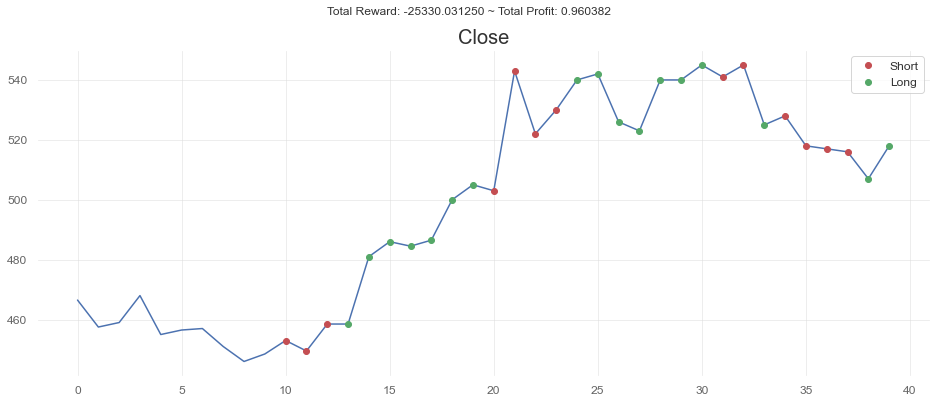

In [34]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


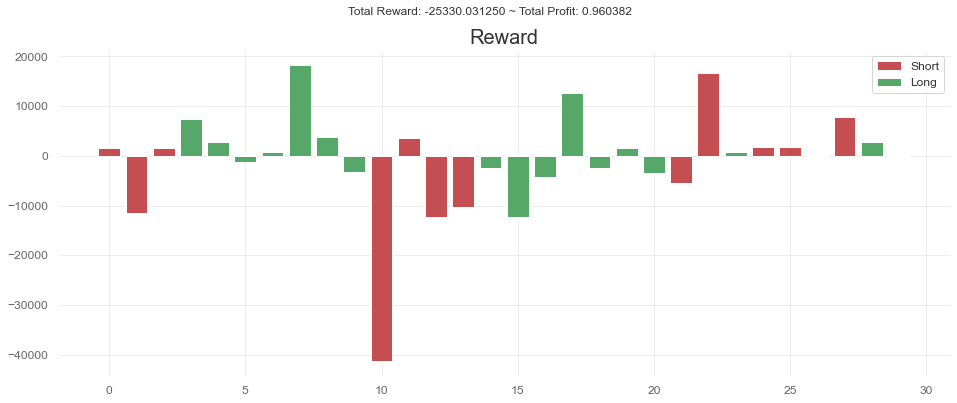

In [35]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


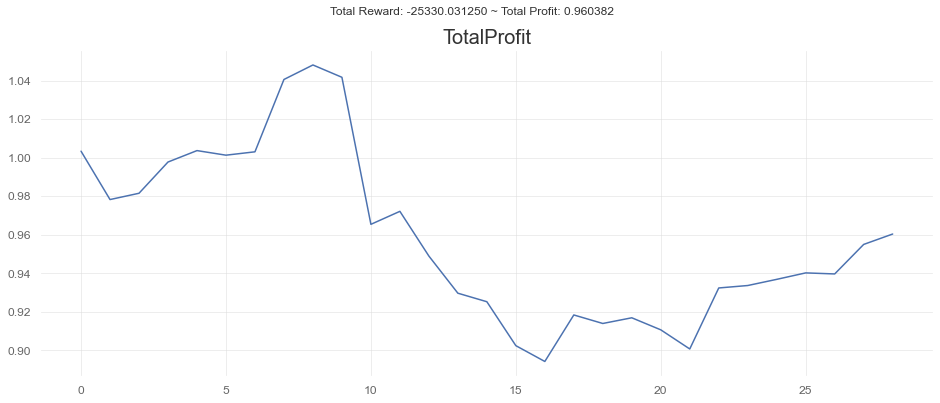

In [36]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [19]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)